In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chrislam/Desktop/sculpting/'

Trying to reproduce Fig 4 from Linbach & Turner 2014 (ie. polynomial fits to CDF of eccentricity-multiplicity in order to properly draw eccentricities for simulated systems)

[0.01       0.01098541 0.01206793 0.01325711 0.01456348 0.01599859
 0.01757511 0.01930698 0.02120951 0.02329952 0.02559548 0.02811769
 0.03088844 0.03393222 0.03727594 0.04094915 0.04498433 0.04941713
 0.05428675 0.05963623 0.06551286 0.07196857 0.07906043 0.08685114
 0.09540955 0.10481131 0.11513954 0.12648552 0.13894955 0.1526418
 0.16768329 0.184207   0.20235896 0.22229965 0.24420531 0.26826958
 0.29470517 0.32374575 0.35564803 0.39069399 0.42919343 0.47148664
 0.51794747 0.5689866  0.62505519 0.68664885 0.75431201 0.82864277
 0.91029818 1.        ]


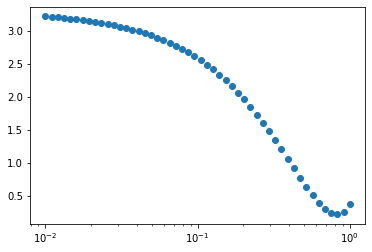

In [2]:
def eccentricity_cdf(x, multiplicity):
    if multiplicity == 1:
        return 4.5973*x**2 - 7.5154*x + 3.2896
    
    elif multiplicity == 2:
        return -4.8646*x + 3.1826
    
    elif (multiplicity == 5) or (multiplicity == 6):
        return -22.1994*x + 6.4972

x = np.logspace(-2, 0)
print(x)
plt.scatter(x, eccentricity_cdf(x, 1))
plt.xscale('log')
plt.show()

Nope, it's clear from the constants that this doesn't correspond to Fig 4. Instead, used Sarah's data-grabbed (from WebPlotDigitizer) points on the Limbach & Turner CDF. 

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_876/839323068.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  limbach = pd.read_csv(path+'limbach_cdfs.txt', header=0, sep='\s{2,20}') # space-agnostic separator


   Eccentricity         1         2         3         4         5         6  \
0      0.010000  0.001477  0.001437  0.002064  0.002554  0.003306  0.003306   
1      0.010471  0.003017  0.002940  0.004221  0.005224  0.006785  0.006785   
2      0.010965  0.004625  0.004513  0.006476  0.008015  0.010443  0.010443   
3      0.011482  0.006303  0.006160  0.008834  0.010932  0.014287  0.014287   
4      0.012023  0.008054  0.007883  0.011300  0.013980  0.018323  0.018323   

          7         8  
0  0.006202  0.006202  
1  0.012660  0.012660  
2  0.019385  0.019385  
3  0.026389  0.026389  
4  0.033687  0.033687  
   Eccentricity         1         2         3         4         5         6  \
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1      0.000471  0.001541  0.001503  0.002157  0.002670  0.003479  0.003479   
2      0.000493  0.001608  0.001573  0.002255  0.002791  0.003658  0.003658   
3      0.000517  0.001678  0.001647  0.002358  0.002917  0.003844

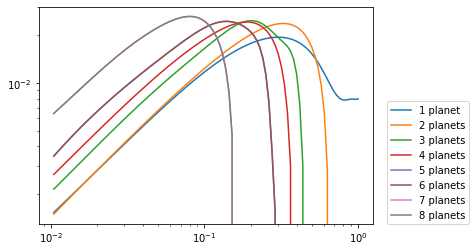

In [3]:
limbach = pd.read_csv(path+'limbach_cdfs.txt', header=0, sep='\s{2,20}') # space-agnostic separator
limbach_pdf = limbach.diff()
print(limbach.head())
print(limbach_pdf.head())
plt.plot(limbach['Eccentricity'], limbach_pdf['1'], label='1 planet')
plt.plot(limbach['Eccentricity'], limbach_pdf['2'], label='2 planets')
plt.plot(limbach['Eccentricity'], limbach_pdf['3'], label='3 planets')
plt.plot(limbach['Eccentricity'], limbach_pdf['4'], label='4 planets')
plt.plot(limbach['Eccentricity'], limbach_pdf['5'], label='5 planets')
plt.plot(limbach['Eccentricity'], limbach_pdf['6'], label='6 planets')
plt.plot(limbach['Eccentricity'], limbach_pdf['7'], label='7 planets')
plt.plot(limbach['Eccentricity'], limbach_pdf['8'], label='8 planets')
plt.xscale('log')
plt.yscale('log') # actually should be basey=np.e
#plt.ylim(0.03, 0.6)
plt.legend(loc=(1.04,0))
plt.show()

Ok, great (amplitude is not the same, but that depends on the fineness of grid, so as long as the shape is good, it's good), but I need to sample from the CDF itself. This was just to confirm that the CDF I was given was correct.

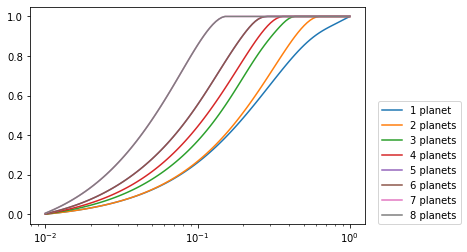

In [4]:
plt.plot(limbach['Eccentricity'], limbach['1'], label='1 planet')
plt.plot(limbach['Eccentricity'], limbach['2'], label='2 planets')
plt.plot(limbach['Eccentricity'], limbach['3'], label='3 planets')
plt.plot(limbach['Eccentricity'], limbach['4'], label='4 planets')
plt.plot(limbach['Eccentricity'], limbach['5'], label='5 planets')
plt.plot(limbach['Eccentricity'], limbach['6'], label='6 planets')
plt.plot(limbach['Eccentricity'], limbach['7'], label='7 planets')
plt.plot(limbach['Eccentricity'], limbach['8'], label='8 planets')
plt.xscale('log')
#plt.yscale('log', basey=10) # actually should be basey=np.e
#plt.ylim(0.03, 0.6)
plt.legend(loc=(1.04,0))
plt.show()

In [5]:
values = np.random.rand(1) 
print(values)
print(limbach['1'])
value_bins = np.searchsorted(limbach['1'], values) # return positions in cdf vector where random values should go
print(value_bins)
random_from_cdf = np.logspace(-2,0,101)[value_bins] # select x_d positions based on these random positions
print(random_from_cdf)

[0.23263771]
0      0.001477
1      0.003017
2      0.004625
3      0.006303
4      0.008054
         ...   
96     0.968269
97     0.976178
98     0.984131
99     0.992040
100    1.000000
Name: 1, Length: 101, dtype: float64
[48]
[0.09120108]


#### Calculate AMD

In [9]:
G = 6.6743e-8 # gravitational constant in cgs

def calculate_amd(m_pks, m_stars, a_ks, e_ks, i_ks, multiplicity):
    """
    calculate angular momentum deficit following Eqn 13 from Milholland et al 2021
    
    a_ks and i_ks: arrays of arrays, ie. each planet has its own value
    m_stars and e_ks: arrays, ie. each planet in the same system has the same value
    multiplicity: each system has an assigned number
    m_pks: all systems have 5 MEarth fiducial mass
    
    """
    amds = []
    lambda_ks = []
    second_terms = []
    for i, a_ks_elt in enumerate(a_ks):
        temps = []
        for j, a_ks_elt_elt in enumerate(a_ks_elt):
            temp_lambda_k = m_pks * np.sqrt(G*m_stars[i]*au_to_cgs(a_ks_elt_elt))
            temp_second_term = 1 - (np.sqrt(1 - (e_ks[i])**2))*np.cos(i_ks[i][j])
            print(temp_lambda_k)
            print(temp_second_term)
            temps.append(temp_lambda_k * temp_second_term)
        amd = np.sum(temps)
        amds.append(amd)
        
    return amds

calculate_amd(5.974e27, [2e33], [[1.5e13]], [0.01671], [[0]], 1) # AMD of Solar System if it was only Earth

1.0339380169322909e+54
0.00013962179712312395


[1.443602840380054e+50]

Plot AMD vs inclination vs eccentricity to see how it matches with Fig 3 in Milholland et al 2021

#### 10/22/21 

In [7]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
pnum = pnum.drop_duplicates(['kepid'])
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
G = 6.6743e-8 # gravitational constant in cgs

# draw eccentricities using Limbach & Turner 2014 CDFs relating e to multiplicity
limbach = pd.read_csv(path+'limbach_cdfs.txt', header=0, sep='\s{2,20}') # space-agnostic separator

def calculate_eccentricity(multiplicity):
    # draw eccentricities using Limbach & Turner 2014 CDFs relating e to multiplicity
    values = np.random.rand(multiplicity) # draw an eccentricity per planet
    if multiplicity==1:
        value_bins = np.searchsorted(limbach['1'], values) # return positions in cdf vector where random values should go
    elif multiplicity==2:
        value_bins = np.searchsorted(limbach['2'], values) # return positions in cdf vector where random values should go
    elif multiplicity==5:
        value_bins = np.searchsorted(limbach['5'], values) # return positions in cdf vector where random values should go
    elif multiplicity==6:
        value_bins = np.searchsorted(limbach['6'], values) # return positions in cdf vector where random values should go
    random_from_cdf = np.logspace(-2,0,101)[value_bins] # select x_d positions based on these random positions
    
    return random_from_cdf

def calculate_amd(m_pk, m_star, a_ks, e_ks, i_ks, multiplicity):
    """
    calculate angular momentum deficit following Eqn 13 from Milholland et al 2021
    
    a_ks and i_ks: arrays of arrays, ie. each planet has its own value
    m_stars and e_ks: arrays, ie. each planet in the same system has the same value
    multiplicity: each system has an assigned number
    m_pks: all systems have 5 MEarth fiducial mass
    
    """
    #print(m_pk, m_star, a_ks, e_ks, i_ks, multiplicity)
    terms = []
    for i, a_ks_elt in enumerate(a_ks):
        lambda_k = m_pk * np.sqrt(G*m_star*au_to_cgs(a_ks_elt))
        second_factor = 1 - (np.sqrt(1 - (e_ks[i])**2))*np.cos(i_ks[i]) 
        terms.append(lambda_k*second_factor)
    return np.sum(terms) 

def calculate_amd_old(m_pk, m_star, a_ks, e_ks, i_ks, multiplicity):
    """
    calculate angular momentum deficit following Eqn 13 from Milholland et al 2021
    
    a_ks and i_ks: arrays of arrays, ie. each planet has its own value
    m_stars and e_ks: arrays, ie. each planet in the same system has the same value
    multiplicity: each system has an assigned number
    m_pks: all systems have 5 MEarth fiducial mass
    
    """
    
    amds = []
    lambda_ks = []
    second_terms = []
    for i, a_ks_elt in enumerate(a_ks):
        temps = []
        for j, a_ks_elt_elt in enumerate(a_ks_elt):
            temp_lambda_k = m_pk * np.sqrt(G*m_star*au_to_cgs(a_ks_elt_elt))
            temp_second_term = 1 - (np.sqrt(1 - (e_ks[i])**2))*np.cos(i_ks[i][j])
            temps.append(temp_lambda_k * temp_second_term)
        amd = np.sum(temps)
        amds.append(amd)
        
    return amds

def sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, eccentricity, long_periastron, 
                     planets_per_case2, planets_a_case2, inclinations, inclinations_degrees, impact_parameters, 
                     transit_statuses, transit_status1, transit_status2, transit_multiplicities, tdurs, cdpp, 
                     sns, prob_detections, geometric_transit_multiplicity):
    """
    In a loop through Kepler data, keep info on stellar radius, age, and CDPP. 
    But we sample number of planets and their periods, draw midplane for the system, 
    draw inclination from the midplane for each planet, convert period to a, calculate impact parameter b, 
    calculate transit duration, calculate normalized transit duration xi (aka mutual inclination proxy),
    classify each planet as transiting or not
    
    Parameters
    ----------
    r_star: radius of the star in solar radii
    m_star: mass of the star in solar masses
    num_planets: number of planets sampled based on stellar age check
    mu: planetary disk midplane in radians
    sigma: sigma used in drawing planet inclinations from around the midplane; 2 degrees
    r_planet: radius of the planet (not a variable for now; 2 R_Earth)
    age_star: age of the star
    cdpp: 6-hour CDPP of planet
    eccentricity of the system
    longitude of periastron of the system, ie. how the orbit is oriented

    possible **kwargs are empty arrays:
    planets_per_case2
    inclinations
    inclinations_degrees
    planets_a_case2
    impact_parameters
    transit_status
    transit_multiplicities
    geometric_transit_multiplicity
    tdurs
    sns (signal noise ratios)
    
    Returns
    -------
    None: populates a bunch of different lists set up before the loop in which function is called,
    including those for inclination, period, semi-major axis, impact parameter, transit duration,
    transit status, probabilistic and geometric transit multiplicity, S/N, and Fressin detection probabilities
    
    """

    # draw planet periods from loguniform distribution according to num_planets
    planet_per_case2 = list(loguniform.rvs(2, 300, size=num_planets)) 
    planets_per_case2.append(planet_per_case2) 

    # inclinations for impact parameter formula
    inclination = list(np.random.normal(mu, sigma, num_planets))
    #print("mu and sigma: ", mu, sigma)
    inclination = [np.pi/2 if inc_elt > np.pi/2 else inc_elt for inc_elt in inclination] # artificially impose bounds post-facto
    inclination = [-np.pi/2 if inc_elt < -np.pi/2 else inc_elt for inc_elt in inclination] # lower bound
    #print("i: ", inclination)
    inclinations.append(inclination) 
    inclination_degrees = [inc*180/np.pi for inc in inclination]
    inclinations_degrees.append(inclination_degrees) 

    # semi-major axes based on Kepler's Third Law
    #planet_a_case2 = [day_to_year(ppc2)**(2./3) for ppc2 in planet_per_case2]
    #planet_a_case2 = [au_to_solar_radius(day_to_year(ppc2)**(2./3)) for ppc2 in planet_per_case2]
    planet_a_case2 = [p_to_a(ppc2, m_star) for ppc2 in planet_per_case2] # in AU
    planet_a_case2_solar_radius = [au_to_solar_radius(p_to_a(ppc2, m_star)) for ppc2 in planet_per_case2] # in solar radii
    planets_a_case2.append(planet_a_case2) 

    # calculate impact parameters; distance units in solar radii
    b = (planet_a_case2_solar_radius * np.sin(inclination))/r_star
    impact_parameters.append(list(b))
    
    # note individual planets' *geometric* transit status; ignores S/N
    ts1 = [1 if np.abs(param) <= 1. else 0 for param in b]
    transit_status1.append(ts1)
    
    # calculate transit durations using Winn 2011 formula; same units as period
    #print("period: ", planet_per_case2)
    #print("b: ", b)
    #print("semi-major axis: ", planet_a_case2)
    #print("i: ", inclination)
    tdur = transit_duration(planet_per_case2, solar_radius_to_au(r_star), 
                            earth_radius_to_au(r_planet), b, planet_a_case2, inclination) 
    #print("TDUR: ", tdur)
    tdurs.append(tdur) # days
    
    # draw jmags based on age-jmag relation, given age
    #jmag = build_and_sample_from_2dpdf(berger_kepler.iso_age, berger_kepler.jmag, age_star)
    #jmags.append(jmag)
    
    # calculate S/N using Christiansen et al 2012 Eqn 4; input
    sn = calculate_sn(planet_per_case2, r_planet, r_star, cdpp, tdur) # time units in days
    sns.append(sn)
    
    # calculate Fressin detection probability based on S/N
    #ts2 = [1 if sn_elt >= 7.1 else 0 for sn_elt in sn] # S/N threshold before Fressin et al 2013
    prob_detection = np.array([0.1*(sn_elt-6) for sn_elt in sn]) # S/N threshold using Fressin et al 2013
    prob_detection[np.isnan(prob_detection)] = 0 # replace NaNs with zeros
    prob_detection = np.where(prob_detection < 0., 0., prob_detection) # replace negative probs with zeros
    # actually, replace all probabilities under 5% with 5% to avoid over-penalizing models which terminate at 0% too early
    prob_detection = np.where(prob_detection > 1, 1, prob_detection) # replace probs > 1 with just 1
    prob_detections.append(prob_detection)
    
    # sample transit status and multiplicity based on Fressin detection probability
    #transit_status = [ts1_elt * ts2_elt for ts1_elt, ts2_elt in zip(ts1, ts2)]
    transit_status = [np.random.choice([1, 0], p=[pd, 1-pd]) for pd in prob_detection]
    transit_statuses.append(transit_status)
    transit_multiplicities.append(len([ts for ts in transit_status if ts == 1]))
    #transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))

    # transit check based on solely on impact parameters, ie. solely on geometry, not noise limit
    geometric_transit_multiplicity.append(len([t for t in ts1 if t == 1]))
    
    return planet_a_case2, inclination_degrees

def compute_prob(x, m, b, cutoff): # adapted from Ballard et al in prep
    # calculate probability of intact vs disrupted
    #y = []
    cutoff = 0 # placeholder
    if x <= 0.1: # assume any decay starts at 1e8 yrs
        y = b
    elif x > 0.1:
        #print(np.log10(x), m, b)
        y = b + m*(x-0.1) # offset by 1e8 yrs to get max(t=index) = 1
        if y < 0: # handle negative probabilities
            y = 0
        elif y > 1: # handle cases where 1-y < 0
            y = 1
            
    return y

def compute_prob2(x, m, b, cutoff): # adapted from Ballard et al in prep, log version
    # calculate probability of intact vs disrupted
    x = x*1e9
    if x <= 1e8: # we don't care about (nor do we have) systems before 1e8 years
        y = b

    elif (x > 1e8) & (x <= cutoff): # pre-cutoff regime
        #print(np.log10(x_elt), m, b)
        y = b + m*(np.log10(x)-8)

    elif x > cutoff: # if star is older than cutoff, use P(intact) at cutoff time
        y = b + m*(np.log10(cutoff)-8)

    if y < 0: # handle negative probabilities
        y = 0
    elif y > 1:
        y = 1
            
    return y

def model_direct_draw(cube):
    """
    Take prior and draw systems out of Kepler data 
    Params: n-dim hypercube prior
    Returns: lambdas and simulated transit DataFrame
    """
    # retrieve prior
    #print(cube)
    m, b, cutoff = cube[0], cube[1], cube[2]
    
    kepids = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    eccentricities = []
    long_periastrons = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    star_mass = []
    impact_parameters = []
    transit_status1 = []
    transit_status2 = []
    transit_statuses = []
    transit_multiplicities = []
    geometric_transit_multiplicity = []
    tdurs = []
    jmags = []
    sns = []
    prob_detections = []
    xi = []
    xi_old = []
    xi_young = []
    prob_intacts = []
    amds = []
    num_planets_all = []
    intact_flags = []
    intacts = 0
    
    # draw ~20000 systems
    num_samples = len(berger_kepler)
    #num_samples = 100
    for i in range(len(berger_kepler[0:num_samples])):
    #for i in range(10):
        ### star ###
        kepids.append(berger_kepler.kepid[i])
        r_star = berger_kepler.iso_rad[i] # in solar radii
        m_star = berger_kepler.iso_mass[i] # in solar masses
        age_star = berger_kepler.iso_age[i]
        mu = list(np.random.uniform(-np.pi/2,np.pi/2,1)) # create midplane for star 
        midplanes.append(mu)
        midplanes_degrees.append([mu_elt*180/np.pi for mu_elt in mu])
        cdpp = berger_kepler.rrmscdpp06p0[i] # don't convert from ppm to parts per unit

        ### planet ###
        r_planet = 2. # use two Earth radii; will make negligible difference
        m_planet = 5. # from Chen & Kipping 2016
        
        """
        # calculate probability given age using piecewise model
        #print("m, b, cutoff: ", m, b, cutoff)
        #print("age star: ", age_star)
        if age_star < cutoff: # if decay cutoff hasn't occurred yet, follow decay model
            prob = m * age_star + b
        else: # if decay cutoff has occurred, use P(intact) at time when cutoff occurred
            prob = m * cutoff + b 
        """

        """
        # not including piecewise/cutoff model
        prob = m * age_star + b

        if prob < 0.: # don't allow negative probabilities
            prob = 0.
        """

        prob = compute_prob2(age_star, m, b, cutoff)
        prob_intacts.append(prob)
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            intacts += 1
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 
            sigma = np.pi/90 # 2 degrees, per Fig 6 in Fabrycky 2012
            eccentricity = calculate_eccentricity(num_planets)
            long_periastron = np.random.uniform(0,2*np.pi,num_planets) 
            
            # simulate transit-related characteristics for 5 or 6 planets
            planet_a_case2, inclination_degrees = sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, eccentricity, long_periastron,
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees,
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2, 
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections, 
                             geometric_transit_multiplicity = geometric_transit_multiplicity)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 
            sigma = np.pi/22.5 # 8 degree disk plane inclination scatter
            eccentricity = calculate_eccentricity(num_planets)
            long_periastron = np.random.uniform(0,2*np.pi,num_planets) 
            
            # simulate transit-related characteristics for 1 or 2 planets
            planet_a_case2, inclination_degrees = sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, eccentricity, long_periastron,
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees, 
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2,
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections,
                             geometric_transit_multiplicity = geometric_transit_multiplicity)

        num_planets_all.append(num_planets)
        eccentricities.append(eccentricity)
        long_periastrons.append(long_periastron)
        intact_flags.append(intact_flag)
        
        # calculate AMD per system
        amd = calculate_amd(earth_mass_to_cgs(m_planet), solar_mass_to_cgs(m_star), 
                        planet_a_case2, eccentricity, inclination_degrees, num_planets)
        amds.append(amd)
        
    # calculate AMD per system
    #amds = calculate_amd(earth_mass_to_cgs(m_planet), solar_mass_to_cgs(berger_kepler.iso_mass[0:num_samples]), 
    #                    planets_a_case2, eccentricities, inclinations, num_planets)

    # calculate inclination offset from midplane for AMD plotting
    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list
    #print(midplanes_degrees)
    midplanes_degrees = np.concatenate(midplanes_degrees, axis=0) # turn list of lists of one into regular list
    #print(midplanes_degrees)
    #print(inclinations_degrees)
    #inc_from_midplane_degrees = np.abs(midplanes_degrees - inclinations_degrees)
    
    # intact fractions
    intact_fractions = intacts/num_samples
    
    """
    transits_dict = {'star_ages': berger_kepler.iso_age, 'planet_periods': planets_per_case2, 
    'semi_major_axes': planets_a_case2, 'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                     'planet_inclinations': inclinations, 'planet_inclinations_degrees': inclinations_degrees,
                     'impact_parameters': impact_parameters, 'transit_status': transit_statuses, 
                     'transit_multiplicity': transit_multiplicities, 'kepid': kepids,
                     'y_intercept': b, 'slope': m, 'transit_duration': tdurs, 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0, 'signal_noise': sns,
                     'prob_detections': prob_detections}
    """
    transits_dict = {'star_ages': berger_kepler.iso_age[0:num_samples], 'planet_periods': planets_per_case2[0:num_samples], 
    'semi_major_axes': planets_a_case2[0:num_samples], 'midplane': midplanes[0:num_samples], 'midplane_degrees': midplanes_degrees[0:num_samples],
                     'planet_inclinations': inclinations[0:num_samples], 'planet_inclinations_degrees': inclinations_degrees[0:num_samples],
                     'eccentricities': eccentricities[0:num_samples], 'amds': amds[0:num_samples], 'long_periastons': long_periastrons[0:num_samples],
                     'impact_parameters': impact_parameters[0:num_samples], 'transit_status': transit_statuses[0:num_samples], 
                     'geometric_transit': transit_status1[0:num_samples], 'geometric_transit_multiplicity': geometric_transit_multiplicity[0:num_samples],
                     'transit_multiplicity': transit_multiplicities[0:num_samples], 'kepid': kepids[0:num_samples],
                     'y_intercept': b*np.ones(num_samples), 'slope': m*np.ones(num_samples), 'transit_duration': tdurs[0:num_samples], 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0[0:num_samples], 'signal_noise': sns[0:num_samples],
                     'prob_detections': prob_detections[0:num_samples], 'prob_intacts': prob_intacts[0:num_samples],
                    'num_planets': num_planets_all[0:num_samples], 'intact_flags': intact_flags[0:num_samples]}
                    #'inc_from_midplane_degrees': inc_from_midplane_degrees[0:num_samples]}
    
    #length_dict = {key: len(value) for key, value in transits_dict.items()}
    #print(length_dict)
    transits = pd.DataFrame(transits_dict)  
    #print(m, b, prob_intacts)
    
    #lam = transits.transit_multiplicity.value_counts()
    #lam = transits.loc[transits.transit_multiplicity > 0].transit_multiplicity.value_counts() * (np.sum(k_old)/len(transits.loc[transits.transit_multiplicity > 0]))
    #lam = transits.loc[transits.transit_multiplicity > 0].transit_multiplicity.value_counts() * (len(berger_kepler)/num_samples) # scale up to full counts of k
    lam = transits.transit_multiplicity.value_counts().reindex(transits.index[0:6], # to deal w/zero value gaps 
                                                               fill_value=0) * (len(berger_kepler)/num_samples)
    geom_lam = transits.geometric_transit_multiplicity.value_counts().reindex(transits.index[0:6], # to deal w/zero value gaps 
                                                               fill_value=0) * (len(berger_kepler)/num_samples)

    lam = lam.to_list()
    geom_lam = geom_lam.to_list()
    return lam, geom_lam, transits, intact_fractions, amds, eccentricities, inclinations_degrees, midplanes_degrees, num_planets_all, intact_flags

def loglike_direct_draw(cube, ndim, nparams):
    """
    Poisson log likelihood from synthetic-posteriors.ipynb
    1st iteration of bridge function between model_direct_draw() and better_logllike()

    Returns: Poisson log-likelihood
    """
    # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
    lam, transits, intact_fractions = model_direct_draw(cube)
    #print("MODEL: ", lam)
    #print("DATA: ", k) # from Berger et al 2020 crossmatched with Gaia via Bedell's kepler-gaia.fun
    
    term1 = np.sum(k) * np.log(lam)
    term2 = -np.sum(lam)
    term3 = -np.sum([lgamma(kth + 1) for kth in k])
    poisson_loglikelihood = term1 + term2 + term3
    #print("POISSON: ", poisson_loglikelihood)
    return poisson_loglikelihood, lam, transits, intact_fractions

def loglike_direct_draw_better(cube, ndim, nparams, k):
    """
    Run model per hyperparam draw and calculate Poisson log likelihood
    2nd iteration of bridge function between model_direct_draw() and better_logllike()
    Includes geometric transit multiplicity and 0 handling.
    Commented out the zero handling because it's wrong.

    Params: 
    - cube: hyperparam cube of slope and intercept
    - ndim: number of dimensions
    - nparams: number of parameters
    - k: from Berger et al 2020
    Returns: Poisson log-likelihood
    """

    # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
    lam, geom_lam, transits, intact_fractions, amds, eccentricities, inclinations_degrees, midplanes_degrees, num_planets_all, intact_flags = model_direct_draw(cube)
    #lam = [1e-12 if x==0.0 else x for x in lam] # avoid -infs in logL by turning 0 lams to 1e-12
    #geom_lam = [1e-12 if x==0.0 else x for x in geom_lam] # ditto
    logL = better_loglike(lam, k)
    geom_logL = better_loglike(geom_lam, k)
    
    return logL, lam, geom_lam, geom_logL, transits, intact_fractions, amds, eccentricities, inclinations_degrees, midplanes_degrees, num_planets_all, intact_flags

def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf
    """

    logL = []
    #print(lam)
    for i in range(len(lam)):
        if lam[i]==0:    
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)
        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

def transit_duration(P, r_star, r_planet, b, a, inc): # Winn 2011 Eqn 14
    #print(P, r_star, r_planet, b, a, inc)
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    #print("arg1: ", arg1)
    arg2 = (r_star / np.array(a)) * (arg1 / np.sin(np.pi/2 - np.array(inc))) # was sin(i) but need to adjust for different index
    #arg2 = (r_star / np.array(a)) * arg1
    #print("arg2: ", arg2)
    
    return (np.array(P) / np.pi) * np.arcsin(arg2)

def p_to_a(p, M):
    # Newton's full version of Kepler's Third Law, assuming planet mass m --> 0
    p = p*86400 # days to seconds
    M = M*1.989e30 # solar mass to kg
    a_in_meters = (((p**2) * 6.67e-11 * M)/(4*np.pi**2))**(1./3) # SI units in the house
    a = a_in_meters/(1.496e11) # meters to AU
    #print(p/86400, M/1.989e30, a)
    return a # in AU

def calculate_xi(tdur1, tdur2, P1, P2): # Fabrycky 2012 Eqn 1
    arg1 = tdur1/(P1**(1./3))
    arg2 = tdur2/(P2**(1./3))
    return arg1 / arg2

def day_to_year(per):
    return per/365.24 

def solar_radius_to_au(radius):
    return 0.00465047*radius

def au_to_solar_radius(au):
    return 215.032*au

def earth_radius_to_au(radius):
    return 4.26352e-5*radius

def earth_mass_to_cgs(mass):
    return mass*5.974e27 # grams

def solar_mass_to_cgs(mass):
    return mass*1.989e33 # grams

def au_to_cgs(distance): 
    return distance*1.496e13 # cm

def calculate_sn(P, rp, rs, cdpp, tdur): 
    """
    Calculate S/N per planet using Eqn 4 in Christiansen et al 2012: https://arxiv.org/pdf/1208.0595.pdf
    
    Params: P (days); rp (Earth radii); rs (Solar radii); cdpp (ppm); tdur (days)
    
    Returns: S/N
    """
    tobs = 365*3.5 # days; time spanned observing the target; set to 3.5 years, or the length of Kepler mission
    f0 = 0.92 # fraction of time spent actually observing and not doing spacecraft things
    tcdpp = 0.25 # days; using CDPP for 6 hour transit durations; could change to be more like Earth transiting Sun?
    rp = earth_radius_to_au(rp)
    rs = solar_radius_to_au(rs)
    #print(P, rp, rs, cdpp, tdur)
    
    factor1 = np.sqrt(tobs*f0/np.array(P)) # this is the number of transits
    delta = 1e6*(rp/rs)**2 # convert from parts per unit to ppm
    cdpp_eff = cdpp * np.sqrt(tcdpp/tdur)
    factor2 = delta/cdpp_eff
    sn = factor1 * factor2
    #print(factor1, delta, cdpp_eff, sn)

    return sn

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11x11 3D grid
    Fixed from simulate.py by adding third param (cutoff) and taking m and cutoff into logspace
    Since m and cutoff don't have natural intervals anymore, I'm going to go from 10 to 9 intervals.
    This saves me ~20% runtime (from 11^3 to 1100 runs).
    Okay actually guess not.
    We're doing log(time), so slope is back to being sampled linearly (everything gets logged together later)

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-2,0,11)[gi_m] 
    cube[1] = np.linspace(0,1,11)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.logspace(8,10,11)[gi_c] # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

def loglike_log_params(cube, ndim, nparams, k):
    """
    Run model per hyperparam draw and calculate Poisson log likelihood
    3rd iteration of bridge function between model_direct_draw() and better_logllike()
    Includes correct zero-handling (https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf), 
    as well as introduction of 3rd parameter (cutoff), and log age and slope

    Params: 
    - cube: hyperparam cube of slope and intercept
    - ndim: number of dimensions
    - nparams: number of parameters
    - k: from Berger et al 2020
    Returns: Poisson log-likelihood
    """

    # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
    lam, geom_lam, transits, intact_fractions = model_direct_draw(cube)
    logL = better_loglike(lam, k)
    geom_logL = better_loglike(geom_lam, k)
    
    return logL, lam, geom_lam, geom_logL, transits, intact_fractions

# set up "hypercube" prior and iterate through it while calling model and likelihood functions
ndim = 3
nparams = 3
lams = []
logLs = []
geometric_lams = []
geometric_logLs = []
intact_fracs = []
amds_per_cutoff = []
eccentricities_per_cutoff = []
inclinations_per_cutoff = []
midplanes_per_cutoff = []
num_planets_per_cutoff = []
intact_flags_per_cutoff = []
ms = []
bs = []
cutoffs = []
"""
for gi_m in range(11):
    for gi_b in range(11):
        cube = [random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = prior_grid_logspace(cube, ndim, nparams, gi_m, gi_b, gi_c) # move to new position on cube
        print(cube)
        logL, lam, geom_lam, geom_logL, transits, intact_fractions = loglike_direct_draw_better(cube, ndim, nparams, k)
"""
"""
for gi_m in range(11):
    for gi_b in range(11):
        cube = [0,0,0]
        gi_c = 0
        ndim = 3
        nparams = 3
        cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
        print(cube)
"""    
for gi_m in [1,5,10]: # do middle of param space
    for gi_b in [1,5,10]:
        gi_c = int(np.linspace(0, 10, 11)[int(6)]) # task_id
        temp_logLs = []
        temp_lams = []
        temp_geom_lams = []
        temp_geom_logLs = []
        temp_intact_fracs = []
        temp_amds = []
        temp_eccentricities = []
        temp_inclinations_degrees = []
        temp_midplanes_degrees = []
        temp_num_planets = []
        temp_intact_flags = []
        #cube = [random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = [0, 0, 0] # instantiate cube
        cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c) # move to new position on cube
        for i in range(1): # ideally should be more
            # calculate logL by comparing model(cube) and k
            logL, lam, geom_lam, geom_logL, transits, intact_fractions, amds, eccentricities, inclinations_degrees, midplanes_degrees, num_planets_all, intact_flags = loglike_direct_draw_better(cube, ndim, nparams, k) 
            #lam = lam.to_list()
            temp_lams.append(lam)
            temp_logLs.append(logL)
            temp_geom_lams.append(geom_lam)
            temp_geom_logLs.append(geom_logL)
            temp_intact_fracs.append(intact_fractions)
            temp_amds.append(amds)
            temp_eccentricities.append(eccentricities)
            temp_inclinations_degrees.append(inclinations_degrees) 
            temp_midplanes_degrees.append(midplanes_degrees) 
            temp_num_planets.append(num_planets_all)
            temp_intact_flags.append(intact_flags)
            #transits.to_csv('/blue/sarahballard/c.lam/sculpting/transits_w_cutoff/transits'+str(gi_m)+'_'+str(gi_b)+'_'+str(gi_c)+'_'+str(i)+'.csv')

        ms.append(round(cube[0],1))
        bs.append(round(cube[1],1))
        cutoffs.append(round(cube[2],1))
        lams.append(temp_lams)
        geometric_lams.append(temp_geom_lams)
        geometric_logLs.append(temp_geom_logLs)
        logLs.append(temp_logLs)
        intact_fracs.append(temp_intact_fracs)
        amds_per_cutoff.append(temp_amds)
        eccentricities_per_cutoff.append(temp_eccentricities)
        inclinations_per_cutoff.append(temp_inclinations_degrees)
        midplanes_per_cutoff.append(temp_midplanes_degrees)
        num_planets_per_cutoff.append(temp_num_planets)
        intact_flags_per_cutoff.append(temp_intact_flags)
        
df = pd.DataFrame({'ms': ms, 'bs': bs, 'cutoffs': cutoffs, 'intact_fracs': intact_fracs, 'logLs': logLs, 'lams': lams, 
    'geometric_lams': geometric_lams, 'geometric_logLs': geometric_logLs, 'amds': amds_per_cutoff,
    'inclinations_degrees': inclinations_per_cutoff, 'midplanes_degrees': midplanes_per_cutoff,
                   'eccentricities': eccentricities_per_cutoff,
                  'num_planets': num_planets_per_cutoff, 'intact_flags': intact_flags_per_cutoff})
print(df)
#lams.to_csv('lams_cands.csv', index=False)


/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_876/3791662740.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  limbach = pd.read_csv(path+'limbach_cdfs.txt', header=0, sep='\s{2,20}') # space-agnostic separator
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_876/3791662740.py:464: RuntimeWarning: invalid value encountered in sqrt
  arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)


    ms   bs       cutoffs             intact_fracs                  logLs  \
0 -1.8  0.1  1.584893e+09                    [0.0]   [-266.6561220863154]   
1 -1.8  0.5  1.584893e+09   [5.00776203114828e-05]  [-254.94383949406654]   
2 -1.8  1.0  1.584893e+09  [0.0006009314437377935]   [-224.1795951842729]   
3 -1.0  0.1  1.584893e+09                    [0.0]  [-236.18059131638958]   
4 -1.0  0.5  1.584893e+09   [0.000250388101557414]  [-216.21307555905784]   
5 -1.0  1.0  1.584893e+09   [0.017927788071510842]  [-238.68739100683032]   
6  0.0  0.1  1.584893e+09    [0.10040562872452301]   [-229.5584453820253]   
7  0.0  0.5  1.584893e+09     [0.5065351294506485]   [-506.0979885738508]   
8  0.0  1.0  1.584893e+09                    [1.0]   [-823.1808924479566]   

                                           lams  \
0       [[19194.0, 729.0, 46.0, 0.0, 0.0, 0.0]]   
1       [[19199.0, 711.0, 59.0, 0.0, 0.0, 0.0]]   
2       [[19255.0, 666.0, 48.0, 0.0, 0.0, 0.0]]   
3       [[19239.0, 684.0,

In [7]:
k

0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64

In [8]:
amd_df = pd.DataFrame({'inc': df.inclinations_degrees[7], 'mid': df.midplanes_degrees[7], 
                      'ecc': df.eccentricities[7], 'amds': df.amds[7], 'intact_flags': df.intact_flags[7]})
print(amd_df.head())
#print(len(amd_df.mid), len(amd_df.mid[7]))

# explode amd_df on every column
amd_df_exploded = amd_df.apply(pd.Series.explode)
amd_df_exploded['mutual_inc'] = np.abs(amd_df_exploded.inc - amd_df_exploded.mid)
print(amd_df_exploded.head(), len(amd_df_exploded))

                                                 inc  \
0  [[84.02960666845426, 82.04310192400293, 85.266...   

                                                 mid  \
0  [86.37758513254896, -85.10524846122362, -24.83...   

                                                 ecc  \
0  [[0.18197008586099836, 0.039810717055349734, 0...   

                                                amds  \
0  [3.001945479297028e+48, 6.910495400562037e+47,...   

                                        intact_flags  
0  [intact, disrupted, intact, intact, intact, in...  
                                                 inc      mid  \
0  [84.02960666845426, 82.04310192400293, 85.2668...  86.3776   
0                               [-84.56556183929366] -85.1052   
0  [-25.409138670323372, -23.754325525939805, -24... -24.8335   
0  [-63.88627776236986, -66.75947770387704, -63.0... -63.6816   
0  [74.35864209615407, 69.06881373699314, 75.3740...  71.6946   

                                               

In [10]:
inclinations_flattened = [item for sublist in amd_df_exploded.mutual_inc for item in sublist]
#print(inclinations_degrees_flattened)
print(len(inclinations_flattened))

eccentricities_flattened = [item for sublist in amd_df_exploded.ecc for item in sublist]
#print(inclinations_degrees_flattened)
print(len(eccentricities_flattened))

"""
plt.scatter(eccentricities_flattened, inclinations_flattened, s=2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('mutual inclination')
plt.xlabel('eccentricity')
plt.ylim(1e-2, 1e2)
plt.xlim(1e-2, 1e0)
#plt.colorbar()
plt.show()
"""

70503
70503


"\nplt.scatter(eccentricities_flattened, inclinations_flattened, s=2)\nplt.yscale('log')\nplt.xscale('log')\nplt.ylabel('mutual inclination')\nplt.xlabel('eccentricity')\nplt.ylim(1e-2, 1e2)\nplt.xlim(1e-2, 1e0)\n#plt.colorbar()\nplt.show()\n"

#### Test eccentricity sampling, 10/27/21

Why are there evenly spaced spikes in the sns jointplot distribution?

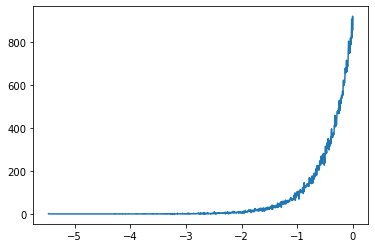

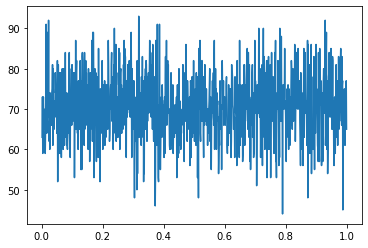

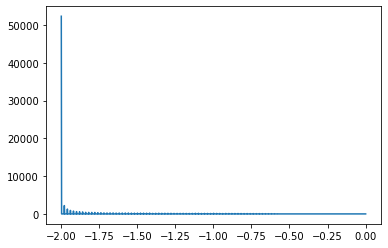

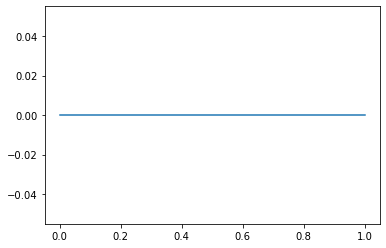

In [11]:
def calculate_eccentricity2(multiplicity):
    if multiplicity==1:
        return 0.01
    elif multiplicity==2:
        return 0.01
    elif multiplicity==5:
        return 0.1
    elif multiplicity==6:
        return 0.1
    
def calculate_eccentricity3(multiplicity):
    values = np.random.rand(multiplicity)
    return values

def calculate_eccentricity_log(multiplicity):
    # draw eccentricities using Limbach & Turner 2014 CDFs relating e to multiplicity
    values = loguniform.rvs(1e-10, 1e0, size=multiplicity) # draw an eccentricity per planet
    if multiplicity==1:
        value_bins = np.searchsorted(limbach['1'], values) # return positions in cdf vector where random values should go
    elif multiplicity==2:
        value_bins = np.searchsorted(limbach['2'], values) # return positions in cdf vector where random values should go
    elif multiplicity==5:
        value_bins = np.searchsorted(limbach['5'], values) # return positions in cdf vector where random values should go
    elif multiplicity==6:
        value_bins = np.searchsorted(limbach['6'], values) # return positions in cdf vector where random values should go
    random_from_cdf = np.logspace(-2,0,101)[value_bins] # select x_d positions based on these random positions
    
    return random_from_cdf

def calculate_eccentricity(multiplicity):
    # draw eccentricities using Limbach & Turner 2014 CDFs relating e to multiplicity
    values = np.random.rand(multiplicity) # draw an eccentricity per planet
    if multiplicity==1:
        value_bins = np.searchsorted(limbach['1'], values) # return positions in cdf vector where random values should go
    elif multiplicity==2:
        value_bins = np.searchsorted(limbach['2'], values) # return positions in cdf vector where random values should go
    elif multiplicity==5:
        value_bins = np.searchsorted(limbach['5'], values) # return positions in cdf vector where random values should go
    elif multiplicity==6:
        value_bins = np.searchsorted(limbach['6'], values) # return positions in cdf vector where random values should go
    random_from_cdf = np.logspace(-2,0,101)[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

#######
ecc3s = []
for i in df.num_planets[7][0]:
    ecc3s.append(calculate_eccentricity3(i))

ecc3s_flattened = [item for sublist in ecc3s for item in sublist]
ecc3s_flattened_log = [np.log10(item) for sublist in ecc3s for item in sublist]

hist, bins = np.histogram(ecc3s_flattened_log, bins=1000)
plt.plot(bins[1:], hist)
plt.show()

hist, bins = np.histogram(ecc3s_flattened, bins=1000)
plt.plot(bins[1:], hist)
plt.show()

#######
ecc_logs = []
for i in df.num_planets[7][0]:
    ecc_logs.append(calculate_eccentricity_log(i))

ecc_logs_flattened = [item for sublist in ecc_logs for item in sublist]
ecc_logs_flattened_log = [np.log10(item) for sublist in ecc_logs for item in sublist]

hist, bins = np.histogram(ecc_logs_flattened_log, bins=1000)
plt.plot(bins[1:], hist)
plt.show()

#######
eccs = []
for i in df.num_planets[7][0]:
    ecc_logs.append(calculate_eccentricity(i))

ecc_flattened = [item for sublist in eccs for item in sublist]
ecc_flattened_log = [np.log10(item) for sublist in eccs for item in sublist]

hist, bins = np.histogram(ecc_flattened_log, bins=1000)
plt.plot(bins[1:], hist)
plt.show()



(20201, 2)
(1, 20201) (20201, 1)
(20201,)
(1, 20201)
[[-3.    -2.   ]
 [-3.    -1.96 ]
 [-3.    -1.92 ]
 ...
 [-0.015  1.9  ]
 [-0.015  1.94 ]
 [-0.015  1.98 ]] [0. 0. 0. ... 0. 0. 0.] [[0. 0. 0. ... 0. 0. 0.]]
[[    1     0]
 [    2     1]
 [    3     2]
 ...
 [20200 10199]
 [20200 10200]
 [20200 20100]] 40000
<matplotlib.tri.triangulation.Triangulation object at 0x7faf0483abe0> [0.0 0.0 0.0 ... 7.085694965815417e-05 8.031573464086514e-05
 7.500454944846659e-05]


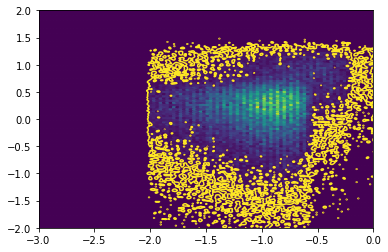

In [13]:
inclinations_flattened_log = [np.log10(item) for sublist in amd_df_exploded.mutual_inc for item in sublist]
eccentricities_flattened_log = [np.log10(item) for sublist in amd_df_exploded.ecc for item in sublist]

h = plt.hexbin(eccentricities_flattened_log, inclinations_flattened_log, gridsize=(100, 100), extent=(-3, 0, -2, 2))
xy = h.get_offsets()
print(xy.shape)
x = h.get_offsets()[:,0] # first column
y = h.get_offsets()[:,1] # second columns
X, Y = np.meshgrid(x, y, sparse=True)
#Y = Y.reshape((1,11558))
print(X.shape, Y.shape)
v = h.get_array()
print(v.shape)
V = v.reshape(X.shape)
print(V.shape)
#v = v.reshape((100, ))
#v_reshaped = v.reshape(xy.shape)
print(xy, v, V)

# triangulation code courtesy of Quadry
triang = []
z = []
"""
for i in range(len(h)):
    z.append(h[i].get_array())
    xy = h[i].get_offsets()
    x = xy[:,0]
    y = xy[:,1]
    triang.append(tri.Triangulation(x, y))
"""
triang = mpl.tri.Triangulation(x, y)
ntri = triang.triangles.shape[0]

# masking badly shaped triangles at the border of the triangular mesh.
min_circle_ratio = .01
mask = mpl.tri.TriAnalyzer(triang).get_flat_tri_mask(min_circle_ratio)
triang.set_mask(mask)

# refining the data
refiner = mpl.tri.UniformTriRefiner(triang)
subdiv = 3
tri_refi, v_refi = refiner.refine_field(v, subdiv=subdiv) # subdiv > 3 --> lots of triangles
print(triang.edges, ntri)
print(tri_refi, v_refi)

plt.tricontour(tri_refi, v_refi, levels=[0.68, 0.95])
#plt.tricontour(x,y,v,levels=[0.68, 0.95], colors='k')
#plt.tricontour(triang.edges,colors='k',levels=[-3,-2,-1] )
#plt.xlim(-1.2, -0.7)
#plt.ylim(-1.,1.5)
plt.show()

#, Y = np.meshgrid(eccentricities_flattened_log, inclinations_flattened_log, sparse=True) # sparse necessary for memory issues
#H = h.get_array().reshape(X.shape) 
#print(X.shape, Y.shape, H.shape)
#cs = plt.contour(V, levels=[68, 95], colors=['#808080', '#A0A0A0'], extend='both')
#cs.cmap.set_over('red')
#cs.cmap.set_under('blue')
#cs.changed()


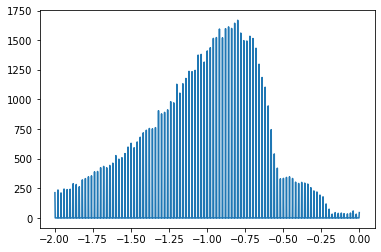

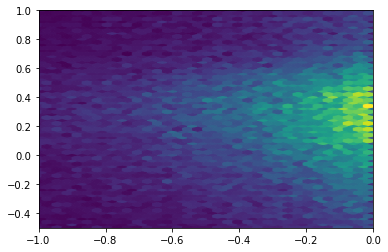

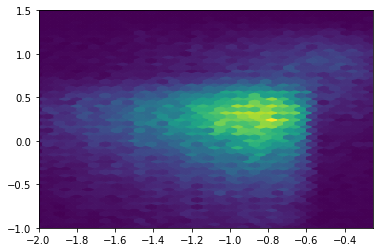

In [14]:
eccs = []
for i in df.num_planets[7][0]:
    eccs.append(calculate_eccentricity(i))

eccs_flattened_log = [np.log10(item) for sublist in eccs for item in sublist]

#print(eccs_flattened_log)
#print(ecc2s)
#hist, bins = np.histogram(eccs_flattened_log, bins=100)
hist, bins = np.histogram(eccentricities_flattened_log, bins=1000)
plt.plot(bins[1:], hist)
plt.show()

h = plt.hexbin(ecc3s_flattened_log, inclinations_flattened_log, gridsize=(100, 100), extent=(-3, 0, -2, 2))
plt.xlim(-1., 0.)
plt.ylim(-0.5, 1.)
plt.show()

h = plt.hexbin(eccentricities_flattened_log, inclinations_flattened_log, gridsize=(50, 50), extent=(-3, 0, -2, 2))
plt.xlim(-2., -0.25)
plt.ylim(-1.,1.5)
plt.show()

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


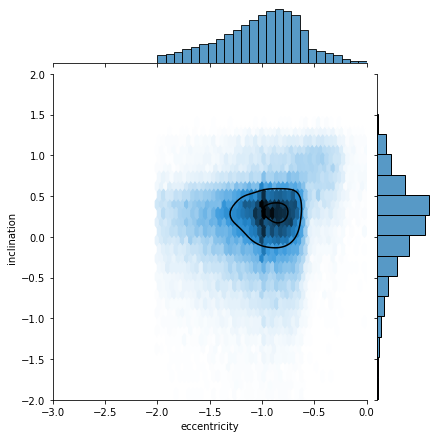

In [55]:
fig = sns.jointplot(eccentricities_flattened_log, inclinations_flattened_log, kind="hex",
                   ylim=(-2,2), xlim=(-3,0), marginal_kws=dict(bins=25))
  
#fig.fig.subplots_adjust(top = 0.85)
  
fig.set_axis_labels('eccentricity', 'inclination')

fig2 = sns.kdeplot(eccentricities_flattened_log, inclinations_flattened_log, legend = True, 
                   levels=[0.68, 0.95], color='black')

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


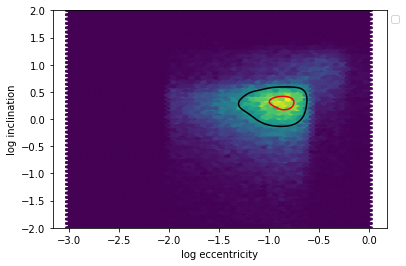

In [89]:
h = plt.hexbin(eccentricities_flattened_log, inclinations_flattened_log, gridsize=(50, 50), extent=(-3, 0, -2, 2))

fig2 = sns.kdeplot(eccentricities_flattened_log, inclinations_flattened_log, legend = True, 
                   levels=[0.68, 0.95], colors=['black','red'])

#plt.xlim(-2., -0.25)
plt.ylim(-2.,2.)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('log inclination')
plt.xlabel('log eccentricity')
plt.show()

20201 20201 20201
3 12


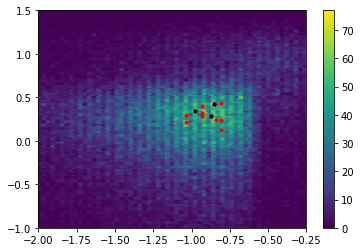

In [29]:
h = plt.hexbin(eccentricities_flattened_log, inclinations_flattened_log, gridsize=(100,100),
          extent=(-3, 0, -2, 2))
plt.colorbar()
xy = h.get_offsets()
x = h.get_offsets()[:,0] # first column
y = h.get_offsets()[:,1] # second columns
X, Y = np.meshgrid(x, y, sparse=True)
v = h.get_array()
print(len(x),len(y),len(v))
#V = v.reshape(X.shape)
#v_reshaped = v.reshape(xy.shape)

hex_df = pd.DataFrame({'x': x, 'y': y, 'v': v})
hex_df_1std = hex_df.loc[hex_df.v >= max(v)-np.std(v)]
hex_df_2std = hex_df.loc[hex_df.v >= max(v)-2*np.std(v)]
print(len(hex_df_1std), len(hex_df_2std))
#print(len(hex_df.drop_duplicates()), hex_df.drop_duplicates().head())
#print(hex_df.loc[(hex_df.y > -1.95) & (hex_df.y < -1.93)])
#print(hex_df.x.unique(), len(hex_df.x.unique()))
#print(hex_df.y.unique(), len(hex_df.y.unique()))

#X, Y = np.meshgrid(eccentricities_flattened, inclinations_flattened, sparse=True) 
#H = h.get_array().reshape(X.shape) 
#print(X.shape, Y.shape, v.shape)
plt.scatter(hex_df_2std.x, hex_df_2std.y, s=10, alpha=1, c='red')
plt.scatter(hex_df_1std.x, hex_df_1std.y, s=10, alpha=1, c='black')
plt.xlim(-2., -0.25)
plt.ylim(-1.,1.5)
plt.show()

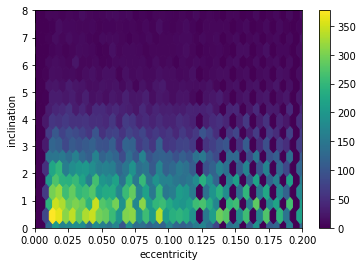

In [23]:
#h = plt.hexbin(eccentricities_flattened, inclinations_flattened, gridsize=100,
#          yscale='log', xscale='log', extent=(-3, 0, -2, 2))
h_linear = plt.hexbin(eccentricities_flattened, inclinations_flattened, gridsize=200,
          extent=(0.001, 1, 0.01, 100))
#X, Y = np.meshgrid(eccentricities_flattened, inclinations_flattened)
#H = h.reshape(X.shape) 
#print(X.shape, Y.shape, H.shape)
#plt.contour(X, Y, H)
plt.ylim(0,8)
plt.xlim(0,0.2)
plt.ylabel('inclination')
plt.xlabel('eccentricity')
plt.colorbar()
plt.show()

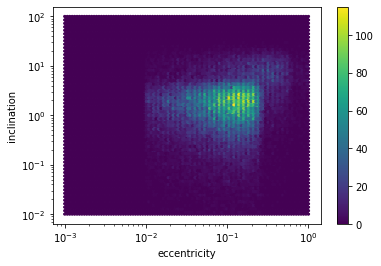

In [9]:
h = plt.hexbin(eccentricities_flattened, inclinations_flattened, gridsize=100,
          yscale='log', xscale='log', extent=(-3, 0, -2, 2)) # reduce_C_function=np.mean, gridsize=100
#plt.ylim(0, 15)
#plt.xlim(0, 0.5)
plt.ylabel('inclination')
plt.xlabel('eccentricity')
plt.colorbar()
plt.show()

#### Split by intact v disrupted

In [78]:
print(len(amd_df_exploded.loc[amd_df_exploded.intact_flags == 'disrupted']))
print(len(amd_df_exploded.loc[amd_df_exploded.intact_flags == 'intact']))
print(len(amd_df_exploded))

9933
10036
19969


In [79]:
amd_df_exploded_intact = amd_df_exploded.loc[amd_df_exploded.intact_flags == 'intact']
amd_df_exploded_disrupted = amd_df_exploded.loc[amd_df_exploded.intact_flags == 'disrupted']
print(amd_df_exploded_intact)

                                                  inc       mid  \
0   [-25.728996281879276, -24.566587311409155, -26...  -27.2322   
0   [-1.0223873259406009, -0.4294907515797112, -2.... -0.987768   
0   [-35.972066119001205, -37.33920550524181, -39....  -38.5772   
0   [38.93374635323282, 39.09596731630868, 36.4511...   37.2172   
0   [5.28343263588471, 8.90173732910927, 9.8506323...   6.22816   
..                                                ...       ...   
0   [-73.95785695671212, -79.96123633571932, -74.4...  -75.5408   
0   [63.39278912998379, 66.00277416566048, 64.1424...   64.8325   
0   [7.805796876314579, 6.749834134005858, 8.33187...   6.46202   
0   [16.58853332604162, 18.854015298643525, 19.503...   18.3841   
0   [57.97393447941665, 59.76328650371868, 57.5292...   56.6191   

                                                  ecc         amds  \
0   [0.12022644346174131, 0.13182567385564073, 0.0...  2.58715e+48   
0   [0.06025595860743578, 0.07943282347242814, 0.2...  

Intact

In [81]:
inclinations_flattened_intact = [np.log10(item) for sublist in amd_df_exploded_intact.mutual_inc for item in sublist]
#print(inclinations_degrees_flattened)
print(len(inclinations_flattened_intact))

eccentricities_flattened_intact = [np.log10(item) for sublist in amd_df_exploded_intact.ecc for item in sublist]
#print(inclinations_degrees_flattened)
print(len(eccentricities_flattened_intact))

"""
plt.scatter(eccentricities_flattened_intact, inclinations_flattened_intact, s=2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('mutual inclination')
plt.xlabel('eccentricity')
plt.ylim(1e-2, 1e2)
plt.xlim(1e-2, 1e0)
#plt.colorbar()
plt.show()
"""

55306
55306


"\nplt.scatter(eccentricities_flattened_intact, inclinations_flattened_intact, s=2)\nplt.yscale('log')\nplt.xscale('log')\nplt.ylabel('mutual inclination')\nplt.xlabel('eccentricity')\nplt.ylim(1e-2, 1e2)\nplt.xlim(1e-2, 1e0)\n#plt.colorbar()\nplt.show()\n"

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


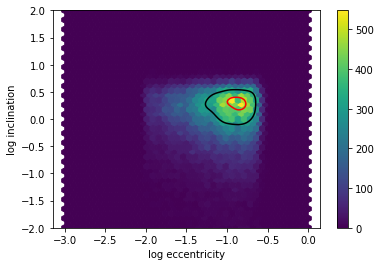

In [85]:
plt.hexbin(eccentricities_flattened_intact, inclinations_flattened_intact, gridsize=40, extent=(-3, 0, -2, 2))

fig2 = sns.kdeplot(eccentricities_flattened_intact, inclinations_flattened_intact, legend = True, 
                   levels=[0.68, 0.95], colors=['black','red'])
plt.ylim(-2, 2)
#plt.xlim(0, 0.5)
plt.xlabel('log eccentricity')
plt.ylabel('log inclination')
plt.colorbar()
plt.show()

Disrupted

In [84]:
inclinations_flattened_disrupted = [np.log10(item) for sublist in amd_df_exploded_disrupted.mutual_inc for item in sublist]
eccentricities_flattened_disrupted = [np.log10(item) for sublist in amd_df_exploded_disrupted.ecc for item in sublist]
print(len(inclinations_flattened_disrupted))

"""
plt.scatter(eccentricities_flattened_disrupted, inclinations_flattened_disrupted, s=2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('mutual inclination')
plt.xlabel('eccentricity')
plt.ylim(1e-2, 1e2)
plt.xlim(1e-2, 1e0)
#plt.colorbar()
plt.show()
"""

14874


"\nplt.scatter(eccentricities_flattened_disrupted, inclinations_flattened_disrupted, s=2)\nplt.yscale('log')\nplt.xscale('log')\nplt.ylabel('mutual inclination')\nplt.xlabel('eccentricity')\nplt.ylim(1e-2, 1e2)\nplt.xlim(1e-2, 1e0)\n#plt.colorbar()\nplt.show()\n"

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


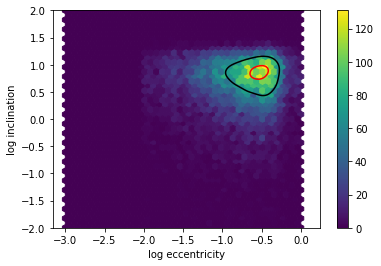

In [88]:
plt.hexbin(eccentricities_flattened_disrupted, inclinations_flattened_disrupted, gridsize=40, extent=(-3, 0, -2, 2)) 
fig2 = sns.kdeplot(eccentricities_flattened_disrupted, inclinations_flattened_disrupted, legend = True, 
                   levels=[0.68, 0.95], colors=['black','red'])

plt.ylim(-2, 2)
#plt.xlim(0, 0.5)
plt.xlabel('log eccentricity')
plt.ylabel('log inclination')
plt.colorbar()
plt.show()

55306 14874


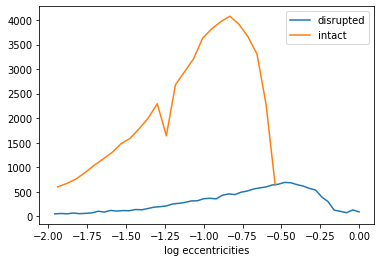

In [102]:
print(len(eccentricities_flattened_intact), len(eccentricities_flattened_disrupted))
hist_disrupted, bins_disrupted = np.histogram(eccentricities_flattened_disrupted, bins=50)
hist_intact, bins_intact = np.histogram(eccentricities_flattened_intact, bins=25)

plt.plot(bins_disrupted[1:], hist_disrupted, label='disrupted')
plt.plot(bins_intact[1:], hist_intact, label='intact')
plt.xlabel('log eccentricities')
plt.legend()
plt.show()

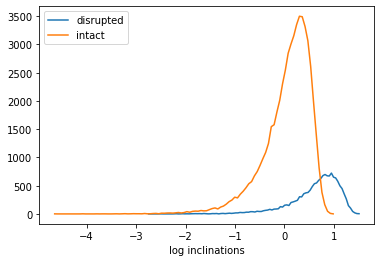

In [94]:
hist_disrupted, bins_disrupted = np.histogram(inclinations_flattened_disrupted, bins=100)
hist_intact, bins_intact = np.histogram(inclinations_flattened_intact, bins=100)

plt.plot(bins_disrupted[1:], hist_disrupted, label='disrupted')
plt.plot(bins_intact[1:], hist_intact, label='intact')
plt.xlabel('log inclinations')
plt.legend()
plt.show()

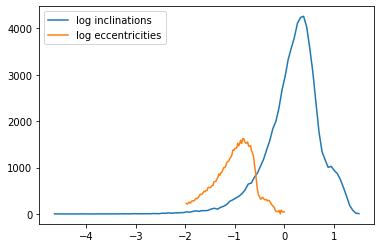

In [95]:
hist_inc, bins_inc = np.histogram(inclinations_flattened_log, bins=100)
hist_ecc, bins_ecc = np.histogram(eccentricities_flattened_log, bins=100)

plt.plot(bins_inc[1:], hist_inc, label='log inclinations')
plt.plot(bins_ecc[1:], hist_ecc, label='log eccentricities')
plt.legend()
plt.show()

#### First stab at ecc vs inc plot during Sarah meeting on 10/16/21

In [178]:
#print(len(df.amds[0][0]), df.amds[0][0])
#print(len(df.eccentricities[0][0]), df.eccentricities[0][0])
#print(len(df.inclinations_degrees[0][0]), df.inclinations_degrees[0][0])
amd_df = pd.DataFrame({'amds': df.amds, 'eccentricities': df.eccentricities, 
                      'inclinations_degrees': df.inclinations_degrees, 
                      'num_planets': df.num_planets})
print(amd_df.head())
amd_df_exploded = amd_df.explode('inclinations_degrees')
amd_df_exploded.eccentricities = amd_df_exploded.eccentricities.apply(lambda x: x[0])
print(amd_df_exploded)
print(len(amd_df_exploded))

                                                amds  \
0  [[1.3845285216684242e+48, 1.3356125380734845e+...   
1  [[5.929163101191587e+47, 1.574406214926997e+48...   
2  [[5.620665658613199e+47, 2.972077257376288e+48...   
3  [[3.499322239949766e+48, 1.9826103871674373e+4...   

                                      eccentricities  \
0  [[[0.17378008287493754], [0.28840315031266056,...   
1  [[[0.26302679918953814], [0.3981071705534973],...   
2  [[[0.8317637711026709], [0.023988329190194897,...   
3  [[[0.13182567385564073, 0.3311311214825911], [...   

                                inclinations_degrees  \
0  [[[-58.40528805008603], [-17.64526258232357, -...   
1  [[[-39.49948907735157], [-10.538022932201526],...   
2  [[[26.95402332250015], [64.92588397271406, 83....   
3  [[[21.77031633603228, 22.349547822968795], [-8...   

                                         num_planets  
0  [[1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1,...  
1  [[1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 

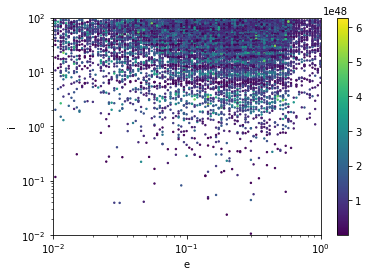

In [134]:
plt.scatter(amd_df_exploded.eccentricities, amd_df_exploded.inclinations_degrees, c=amd_df_exploded.amds, s=2)
plt.xlabel('e')
plt.ylabel('i') # NO. NEED TO BE MUTUAL INC FROM THE MIDPLANE
plt.ylim(1e-2, 1e2)
plt.xlim(1e-2, 1e0)
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.show()

In [11]:
hist, bins = np.histogram(amd_df_exploded.eccentricities, bins=20)
plt.plot(bins[1:], hist)

AttributeError: 'DataFrame' object has no attribute 'eccentricities'

In [145]:
limbach_pdf['1']

0           NaN
1      0.001541
2      0.001608
3      0.001678
4      0.001751
         ...   
96     0.007836
97     0.007909
98     0.007953
99     0.007909
100    0.007960
Name: 1, Length: 101, dtype: float64

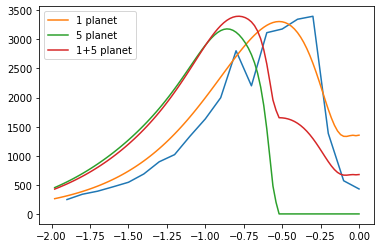

In [168]:
hist, bins = np.histogram(np.log10(amd_df_exploded.eccentricities), bins=20)
plt.plot(bins[1:], hist)

plt.plot(np.log10(limbach['Eccentricity']), limbach_pdf['1']*170000, label='1 planet')
plt.plot(np.log10(limbach['Eccentricity']), limbach_pdf['5']*130000, label='5 planet')
plt.plot(np.log10(limbach['Eccentricity']), 
         (limbach_pdf['1']*170000+limbach_pdf['5']*170000)*0.5, label='1+5 planet')

plt.legend()
plt.show()

#### Actual start

In [21]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [23]:
# redo ms because I forgot that I rounded to single decimal beforehand
ms_corrected = []
ms_corrected_for_plotting = []
for gi_m in range(11):
    for gi_b in range(11):
        ms = -1e-9*np.logspace(8,10,11)[gi_m]
        ms_corrected.append(ms)
        ms_for_plotting = np.log10(np.logspace(8,10,11))[gi_m]
        ms_corrected_for_plotting.append(ms_for_plotting)
print(ms_corrected)
print(ms_corrected_for_plotting)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944

In [24]:
import csv
import ast
from ast import literal_eval

with open('simulations_w_cutoff_and_scaling.csv','r') as csvfile: # simulations_w_logslope.csv
    read_csv = csv.reader(csvfile, delimiter=',')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
print(df.columns)
df.logLs = df.logLs.apply(literal_eval) # convert back from string to list of floats
df.logLs_nonzero1 = df.logLs_nonzero1.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero2 = df.logLs_nonzero2.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero3 = df.logLs_nonzero3.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero4 = df.logLs_nonzero4.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero5 = df.logLs_nonzero5.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero6 = df.logLs_nonzero6.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero7 = df.logLs_nonzero7.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero8 = df.logLs_nonzero8.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero9 = df.logLs_nonzero9.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero10 = df.logLs_nonzero10.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero11 = df.logLs_nonzero11.apply(lambda x: literal_eval(str(x)))

df.lams_nonzero1 = df.lams_nonzero1.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero2 = df.lams_nonzero2.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero3 = df.lams_nonzero3.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero4 = df.lams_nonzero4.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero5 = df.lams_nonzero5.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero6 = df.lams_nonzero6.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero7 = df.lams_nonzero7.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero8 = df.lams_nonzero8.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero9 = df.lams_nonzero9.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero10 = df.lams_nonzero10.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero11 = df.lams_nonzero11.apply(lambda x: literal_eval(str(x)))

df.bs = df.bs.apply(literal_eval)
#df.ms = df.ms.apply(literal_eval)
#df.ms = ms_corrected
df.intact_fracs = df.intact_fracs.apply(literal_eval)

Index(['', '﻿ms', 'bs', 'cutoffs', 'intact_fracs', 'logLs', 'lams',
       'geometric_lams', 'geometric_logLs', 'lams_nonzero1', 'lams_nonzero2',
       'lams_nonzero3', 'lams_nonzero4', 'lams_nonzero5', 'lams_nonzero6',
       'lams_nonzero7', 'lams_nonzero8', 'lams_nonzero9', 'lams_nonzero10',
       'lams_nonzero11', 'logLs_nonzero1', 'logLs_nonzero2', 'logLs_nonzero3',
       'logLs_nonzero4', 'logLs_nonzero5', 'logLs_nonzero6', 'logLs_nonzero7',
       'logLs_nonzero8', 'logLs_nonzero9', 'logLs_nonzero10',
       'logLs_nonzero11'],
      dtype='object')


In [25]:
df_billion = df.loc[df.cutoffs == '1000000000.0'].reset_index()
df_ten_billion = df.loc[df.cutoffs == '10000000000.0'].reset_index()

In [26]:
df_ten_billion.logLs_nonzero1[0][0]

-1283.9783211301603

In [27]:
df_ten_billion

,index,,﻿ms,bs,cutoffs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,...,logLs_nonzero2,logLs_nonzero3,logLs_nonzero4,logLs_nonzero5,logLs_nonzero6,logLs_nonzero7,logLs_nonzero8,logLs_nonzero9,logLs_nonzero10,logLs_nonzero11
0,0,0,-2.0,0.0,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-251.04074034981335, -230.72449915224303, -24...","[[19218.0, 706.0, 45.0, 0.0, 0.0, 0.0], [19242...","[[18631.0, 1209.0, 129.0, 0.0, 0.0, 0.0], [185...","[-675.7197829447643, -702.9327892111107, -598....",...,"[-243.65501863676624, -245.46670573997986, -25...","[-114.27660037158262, -113.68828747479603, -12...","[-69.76439347967394, -66.77608058288737, -75.1...","[-59.99818210639882, -54.60986920961225, -63.1...","[-69.27083446870691, -61.48252157192031, -70.2...","[-90.58597521449025, -80.39766231770344, -89.3...","[-120.21152466544905, -107.62321176866246, -11...","[-155.91976384121492, -140.93145094442835, -15...","[-196.27376832258162, -178.88545542579504, -18...","[-240.29241620352292, -220.50410330673657, -23..."
1,1,1,-2.0,0.1,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-240.84813892048598, -238.77359062808355, -26...","[[19232.0, 691.0, 46.0, 0.0, 0.0, 0.0], [19228...","[[18642.0, 1216.0, 111.0, 0.0, 0.0, 0.0], [186...","[-670.3755327203831, -688.3459121895444, -684....",...,"[-246.37409534314847, -240.61155951650957, -24...","[-115.59567707796464, -110.23314125132569, -11...","[-69.68347018605596, -64.72093435941724, -72.3...","[-58.51725881278083, -53.95472298614195, -64.6...","[-66.38991117508868, -62.2273753484501, -76.02...","[-86.30505192087247, -82.54251609423349, -99.4...","[-114.53060137183101, -111.16806554519232, -13...","[-148.8388405475967, -145.87630472095802, -168...","[-187.79284502896385, -185.23030920232483, -21...","[-230.41149290990492, -228.24895708326622, -25..."
2,2,2,-2.0,0.2,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-226.8544852718304, -244.87091591559098, -256...","[[19252.0, 670.0, 47.0, 0.0, 0.0, 0.0], [19226...","[[18663.0, 1175.0, 131.0, 0.0, 0.0, 0.0], [186...","[-648.1689569678081, -664.5037128647199, -674....",...,"[-250.80763405424793, -244.86457211689205, -25...","[-118.02921578906407, -114.68615385170824, -12...","[-70.11700889715547, -69.3739469597997, -76.02...","[-56.950797523880205, -58.80773558652425, -66....","[-62.82344988618838, -67.28038794883247, -75.3...","[-80.73859063197162, -87.79552869461571, -96.5...","[-106.96414008293047, -116.62107814557461, -12...","[-139.27237925869633, -151.52931732134044, -16...","[-176.226383740063, -191.0833218027074, -201.9...","[-216.84503162100452, -234.3019696836486, -245..."
3,3,3,-2.0,0.3,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-221.5263235240222, -233.9875459133561, -233....","[[19257.0, 662.0, 50.0, 0.0, 0.0, 0.0], [19228...","[[18653.0, 1187.0, 129.0, 0.0, 0.0, 0.0], [186...","[-657.0075951912117, -631.3564379926753, -679....",...,"[-250.0829546379384, -235.82551480178216, -251...","[-116.80453637275446, -105.44709653659828, -11...","[-68.39232948084589, -59.934889644689754, -71....","[-54.72611810757045, -49.1686782714146, -59.49...","[-60.09877046987868, -57.441330633722636, -66....","[-77.51391121566192, -77.75647137950594, -84.6...","[-103.23946066662086, -106.38202083046491, -11...","[-135.04769984238666, -141.09026000623064, -14...","[-171.5017043237536, -180.44426448759754, -182...","[-211.62035220469483, -223.46291236853875, -22..."
4,4,4,-2.0,0.4,10000000000.0,"[0.0, 5.00776203114828e-05, 5.00776203114828e-...","[-232.12663813097117, -222.05429098052548, -24...","[[19244.0, 678.0, 47.0, 0.0, 0.0, 0.0], [19287...","[[18651.0, 1185.0, 133.0, 0.0, 0.0, 0.0], [186...","[-657.9690238243347, -629.2142786189515, -665....",...,"[-248.71145761873433, -278.2040166906443, -243...","[-116.73303935355042, -141.92559842546052, -11...","[-69.62083246164178, -90.5133915335519, -67.85...","[-57.2546210883667, -73.84718016027679, -57.38...","[-63.9272734

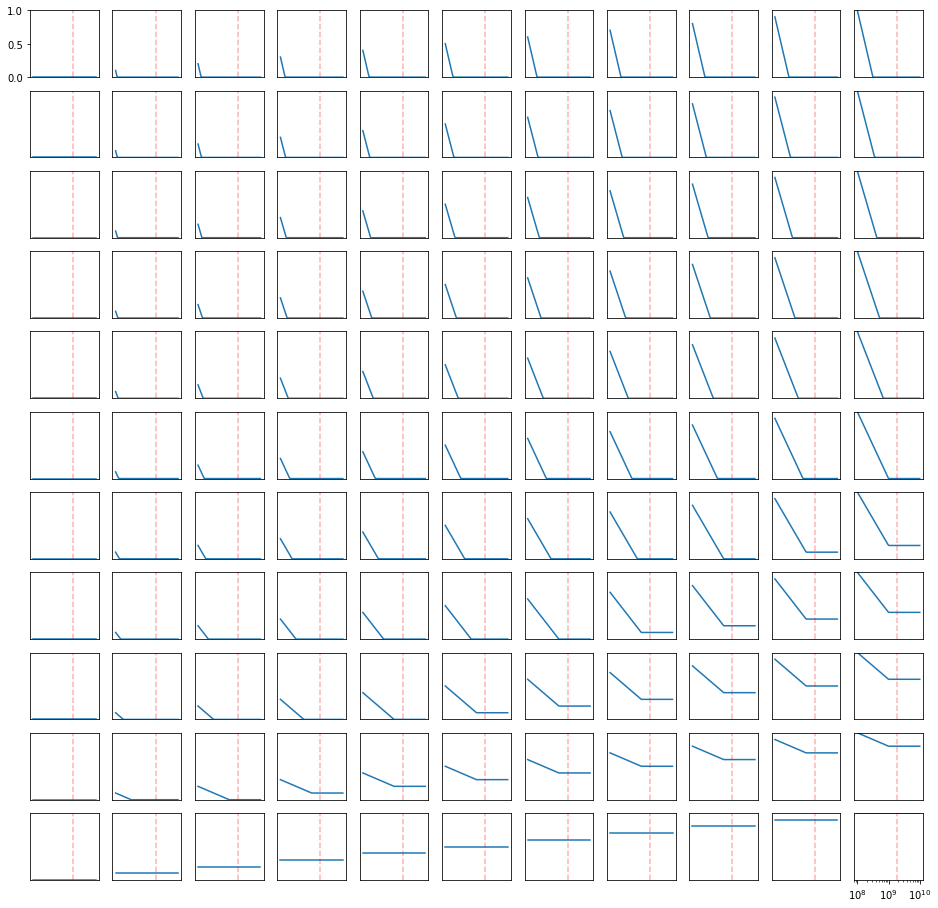

In [28]:
def plot_prob(x, m, b, cutoff):
    #return x*np.log10(m) + b
    #return -np.log10(x*m) + b
    #return -np.log10(x*m) + b # y=mx+b
    #return -np.log10(m * (x-1e8)) + b # linear equation given slope and one point, but with slope and x axis logged
    y = []
    for x_elt in x:
        if x_elt <= 1e8:
            y.append(b)
        elif (x_elt > 1e8) & (x_elt <= cutoff):
            y_elt = b + m*(np.log10(x_elt)-8)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt)
        elif x_elt > cutoff: # if star is older than cutoff, use P(intact) at cutoff time
            y_elt = b + m*(np.log10(cutoff)-8)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt) 
            
    return y

def plot_prob_wrong(x, m, b, cutoff):
    #return x*np.log10(m) + b
    #return -np.log10(x*m) + b
    #return -np.log10(x*m) + b # y=mx+b
    #return -np.log10(m * (x-1e8)) + b # linear equation given slope and one point, but with slope and x axis logged
    y = []
    for x_elt in x:
        if x_elt <= 1e8:
            y.append(b)
        elif (x_elt > 1e8) & (x_elt <= cutoff):
            y_elt = b + m*(np.log10(x_elt)-8)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt)
        elif x_elt > cutoff: # if star is older than cutoff, use P(intact) at cutoff time
            y_elt = b + m*(np.log10(cutoff))
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt) 
            
    return y

x = np.logspace(8, 10, 100)
plt.figure(figsize=(16,16))
index = 0
ms = np.linspace(-2, 0, 11)
for i, gi_m in enumerate(ms):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (i,gi_b))
        #ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        #ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        #cube = [random.uniform(0,1), random.uniform(0,1)]
        #cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        cutoff = 1e9 # placeholder
        
        #print(round(gi_m, 1), df.bs[index])
        y = plot_prob(x, round(gi_m, 1), df.bs[index], cutoff)
        #y = prob_intact(x, round(df.ms[index], 1), df.bs[index], cutoff)
        #y = prob_intact(x, np.linspace(-1,0,11)[gi_m], np.linspace(0,1,11)[gi_b])
        ax.plot(x, y)
        ax.set_ylim([0, 1])
        
        if index < 1:
            ax.get_yaxis().set_visible(True)
        else:
            ax.get_yaxis().set_visible(False)
        
        if index < 120:
            ax.get_xaxis().set_visible(False)
        else:
            ax.get_xaxis().set_visible(True)            

        ax.set_xscale('log')
        
        index += 1
        
        # plot vertical red line through median age of Berger FGK dwarfs
        ax.plot([1e9*np.median(berger_kepler.iso_age), 1e9*np.median(berger_kepler.iso_age)], 
                [0,1], color='r', alpha=0.3, linestyle='--')

#plt.savefig('models.eps', format='eps')
plt.show()

Presentation plots

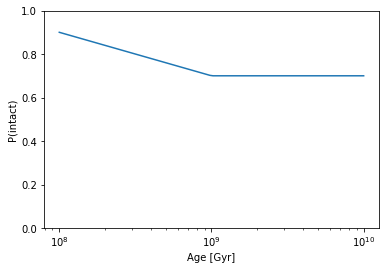

In [29]:
#from matplotlib import rc,rcParams

y = plot_prob(x, round(-0.2, 1), df.bs[9], cutoff)
#y = prob_intact(x, round(df.ms[index], 1), df.bs[index], cutoff)
#y = prob_intact(x, np.linspace(-1,0,11)[gi_m], np.linspace(0,1,11)[gi_b])
#rc('font', weight='bold')

plt.plot(x, y)
plt.ylim([0, 1])         
plt.xscale('log')
plt.ylabel('P(intact)')
plt.xlabel('Age [Gyr]')
plt.savefig('symposium_model1.eps', format='eps')
plt.show()

#### Scaling of 0.1

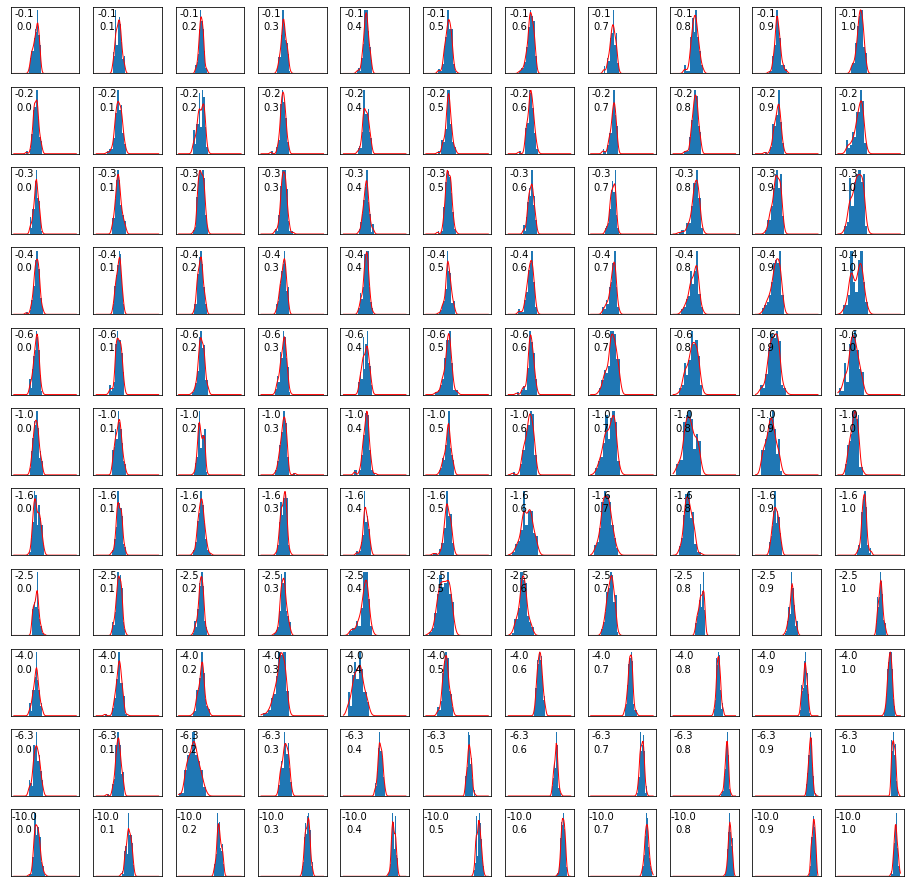

In [30]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero2
lams = df_ten_billion.lams_nonzero2
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

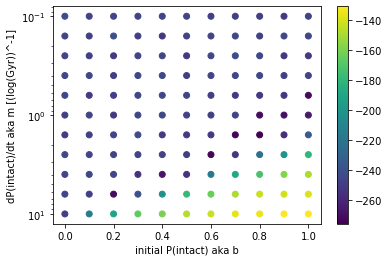

In [31]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/core/_methods.py:163: UserWarning: Warning: converting a masked element to nan.
  arr = asanyarray(a)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2361: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


[75.5, 6.1000000000000005, masked, masked, masked] [62.2, 2.9000000000000004, masked, masked, masked] [68.465, 4.6259999999999994, nan, nan, nan]


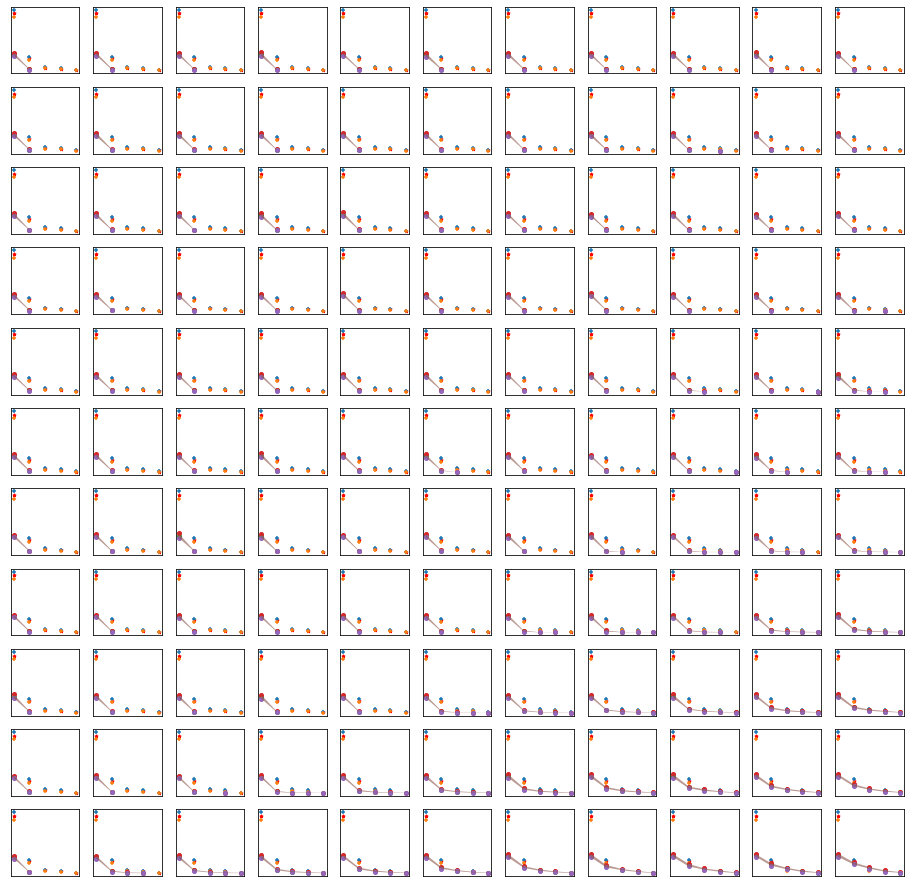

In [32]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays

plt.figure(figsize=(16,16))
index = 0
nonzero_k = k[1:]

#short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        if index==0:
            print(lam_elt_max, lam_elt_min, lam_elt_avg)
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(np.arange(5), nonzero_k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(5), nonzero_k+np.sqrt(nonzero_k), marker='+', s=10)
        ax.scatter(np.arange(5), nonzero_k-np.sqrt(nonzero_k), marker='+', s=10)
        ax.scatter(np.arange(5), lam_elt_avg, s=16)
        ax.scatter(np.arange(5), lam_elt_max, s=16)
        ax.scatter(np.arange(5), lam_elt_min, s=16)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.6)

        index += 1
plt.show()

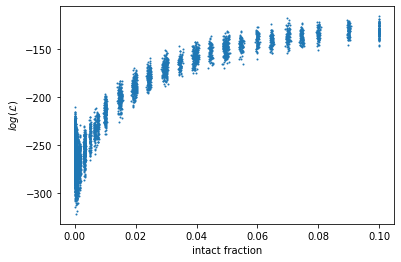

In [33]:
plt.scatter(0.1*df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero2.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
#plt.xlim(0, 0.4)
#plt.ylim(-300, -120)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

#### Note! In future simulations, intact_frac will be split among scaling factors so that we don't have to adjust on an ad hoc basis like above. Also, filtering conditions below to plot best models per scaling factor use pre-scaling-factor-adjusted intact fractions, again, because we didn't create specific intact_frac columns per scaling model.

In [34]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero2 > -460) & (df_exploded.intact_fracs > 0.85) 
                             & (df_exploded.intact_fracs < 0.95)]
print(np.mean(0.1*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero2))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero2))

0.08997801592468324 -130.82442382200804
100
-145.84846217944425


[82.10000000000001, 42.400000000000006, 23.0, 11.4, 4.0] [71.2, 32.5, 16.8, 6.0, 1.6] [77.153, 38.13400000000001, 20.328000000000003, 8.868, 2.781]


[]

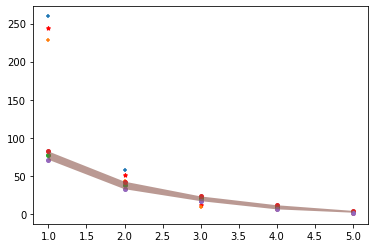

In [35]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero2]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.2

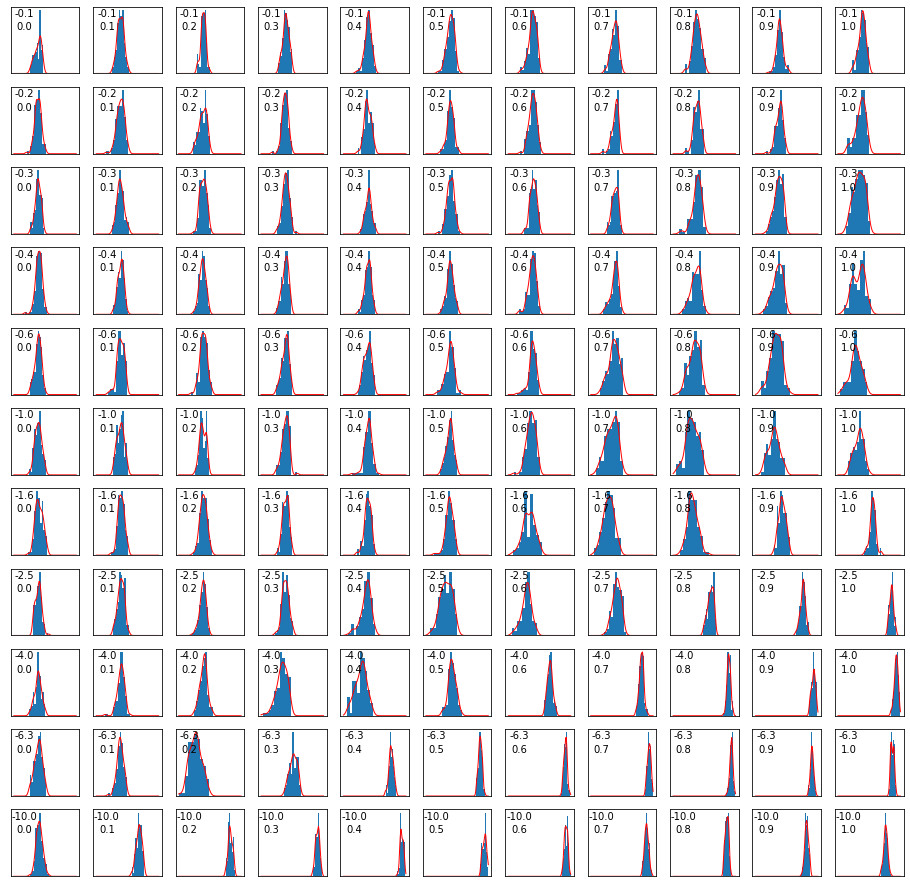

In [36]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero3
lams = df_ten_billion.lams_nonzero3
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

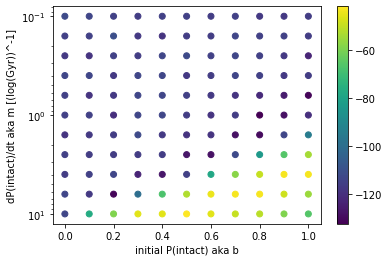

In [37]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

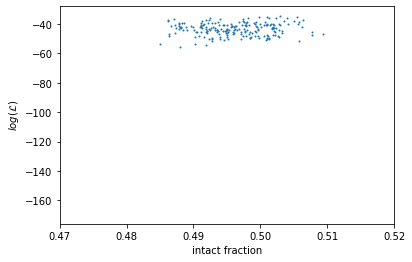

In [38]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero3.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.47, 0.52)
#plt.ylim(-60, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [39]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (0.2*df_exploded.intact_fracs > 0.095) 
                             & (0.2*df_exploded.intact_fracs < 0.105)]
print(np.mean(0.2*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero3))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

0.0992281035605188 -43.54040610654465
200
-115.0963815646512


In [40]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (df_exploded.intact_fracs > 0.47) 
                             & (df_exploded.intact_fracs < 0.52)]
print(np.mean(0.2*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero3))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

0.0992281035605188 -43.54040610654465
200
-115.0963815646512


[159.60000000000002, 52.6, 27.0, 15.0, 4.6000000000000005] [132.8, 37.2, 16.8, 6.6000000000000005, 1.0] [146.042, 45.69200000000001, 22.216000000000005, 9.677999999999999, 2.903]


[]

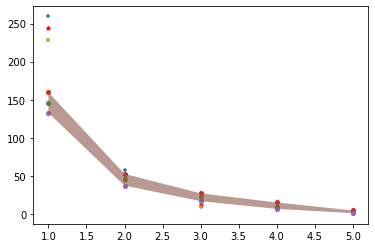

In [41]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero3]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.3

In [ ]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero4
lams = df_ten_billion.lams_nonzero4
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero4.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.2, 0.4)
plt.ylim(-20, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (df_exploded.intact_fracs > 0.275) 
                             & (df_exploded.intact_fracs < 0.325)]
print(np.mean(0.3*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero6))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

In [ ]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero6]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.4

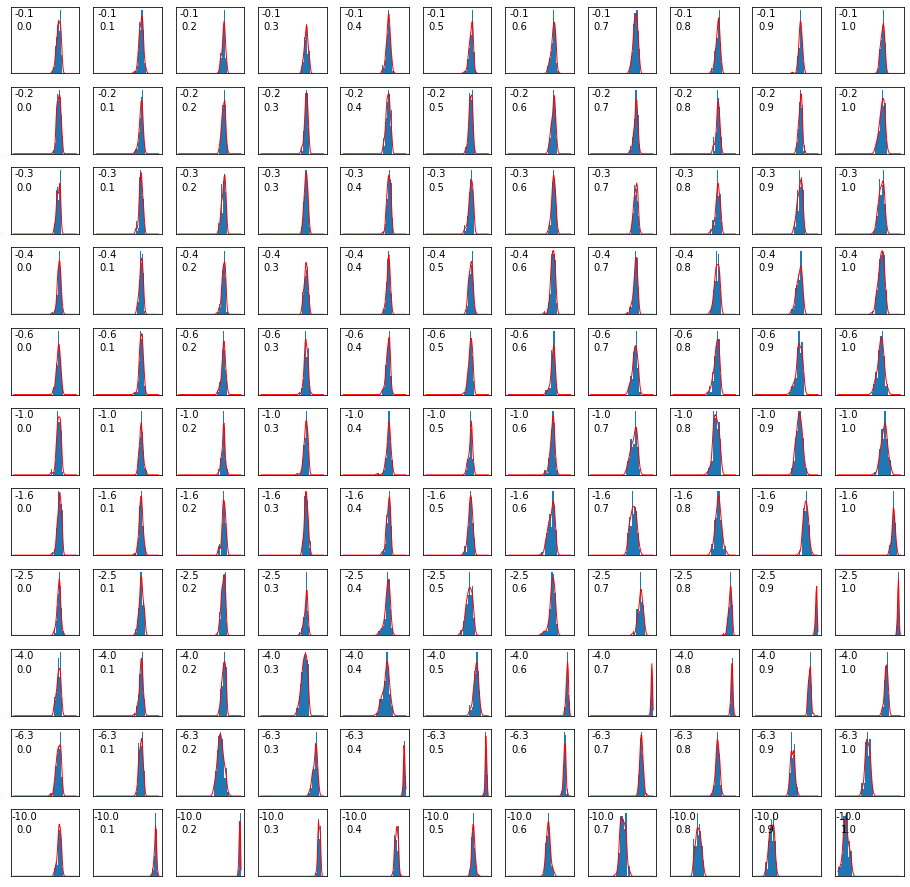

In [42]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero5
lams = df_ten_billion.lams_nonzero5
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

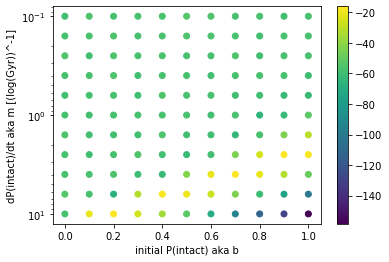

In [43]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [76]:
ms_temp = list(-0.4*np.ones(100))+list(0.0*np.ones(100))
df_exploded1['ms_temp'] = ms_temp # temp solution to df.ms not being readable, for some reason

ms_temp = []
for i in np.linspace(-2., 0., 11):
    ms_temp += list(i*np.ones(11))

df_ten_billion['ms_temp'] = ms_temp
df_ten_billion.head()

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,,﻿ms,bs,cutoffs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,...,logLs_nonzero3,logLs_nonzero4,logLs_nonzero5,logLs_nonzero6,logLs_nonzero7,logLs_nonzero8,logLs_nonzero9,logLs_nonzero10,logLs_nonzero11,ms_temp
0,0,0,-2.0,0.0,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-251.04074034981335, -230.72449915224303, -24...","[[19218.0, 706.0, 45.0, 0.0, 0.0, 0.0], [19242...","[[18631.0, 1209.0, 129.0, 0.0, 0.0, 0.0], [185...","[-675.7197829447643, -702.9327892111107, -598....",...,"[-114.27660037158262, -113.68828747479603, -12...","[-69.76439347967394, -66.77608058288737, -75.1...","[-59.99818210639882, -54.60986920961225, -63.1...","[-69.27083446870691, -61.48252157192031, -70.2...","[-90.58597521449025, -80.39766231770344, -89.3...","[-120.21152466544905, -107.62321176866246, -11...","[-155.91976384121492, -140.93145094442835, -15...","[-196.27376832258162, -178.88545542579504, -18...","[-240.29241620352292, -220.50410330673657, -23...",-2.0
1,1,1,-2.0,0.1,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-240.84813892048598, -238.77359062808355, -26...","[[19232.0, 691.0, 46.0, 0.0, 0.0, 0.0], [19228...","[[18642.0, 1216.0, 111.0, 0.0, 0.0, 0.0], [186...","[-670.3755327203831, -688.3459121895444, -684....",...,"[-115.59567707796464, -110.23314125132569, -11...","[-69.68347018605596, -64.72093435941724, -72.3...","[-58.51725881278083, -53.95472298614195, -64.6...","[-66.38991117508868, -62.2273753484501, -76.02...","[-86.30505192087247, -82.54251609423349, -99.4...","[-114.53060137183101, -111.16806554519232, -13...","[-148.8388405475967, -145.87630472095802, -168...","[-187.79284502896385, -185.23030920232483, -21...","[-230.41149290990492, -228.24895708326622, -25...",-2.0
2,2,2,-2.0,0.2,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-226.8544852718304, -244.87091591559098, -256...","[[19252.0, 670.0, 47.0, 0.0, 0.0, 0.0], [19226...","[[18663.0, 1175.0, 131.0, 0.0, 0.0, 0.0], [186...","[-648.1689569678081, -664.5037128647199, -674....",...,"[-118.02921578906407, -114.68615385170824, -12...","[-70.11700889715547, -69.3739469597997, -76.02...","[-56.950797523880205, -58.80773558652425, -66....","[-62.82344988618838, -67.28038794883247, -75.3...","[-80.73859063197162, -87.79552869461571, -96.5...","[-106.96414008293047, -116.62107814557461, -12...","[-139.27237925869633, -151.52931732134044, -16...","[-176.226383740063, -191.0833218027074, -201.9...","[-216.84503162100452, -234.3019696836486, -245...",-2.0
3,3,3,-2.0,0.3,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-221.5263235240222, -233.9875459133561, -233....","[[19257.0, 662.0, 50.0, 0.0, 0.0, 0.0], [19228...","[[18653.0, 1187.0, 129.0, 0.0, 0.0, 0.0], [186...","[-657.0075951912117, -631.3564379926753, -679....",...,"[-116.80453637275446, -105.44709653659828, -11...","[-68.39232948084589, -59.934889644689754, -71....","[-54.72611810757045, -49.1686782714146, -59.49...","[-60.09877046987868, -57.441330633722636, -66....","[-77.51391121566192, -77.75647137950594, -84.6...","[-103.23946066662086, -106.38202083046491, -11...","[-135.04769984238666, -141.09026000623064, -14...","[-171.5017043237536, -180.44426448759754, -182...","[-211.62035220469483, -223.46291236853875, -22...",-2.0
4,4,4,-2.0,0.4,10000000000.0,"[0.0, 5.00776203114828e-05, 5.00776203114828e-...","[-232.12663813097117, -222.05429098052548, -24...","[[19244.0, 678.0, 47.0, 0.0, 0.0, 0.0], [19287...","[[18651.0, 1185.0, 133.0, 0.0, 0.0, 0.0], [186...","[-657.9690238243347, -629.2142786189515, -665....",...,"[-116.73303935355042, -141.92559842546052, -11...","[-69.62083246164178, -90.5133915335519, -67.85...","[-57.2546210883667, -73.84718016027679, -57.38...","[-63.9272734506746, -76.21983252258471, -65.96...","[-82.64241419645802, -90.6349732683681, -86.57...","[-109.66796364741683, -113.36052271932695, -11...","[-142.77620282318276, -142.16876189509262, -15...","[-180.53020730454938, -175.6227663764597, -190...",

In [82]:
len(df_ten_billion.logLs_nonzero5), len(df_ten_billion.ms_temp),len(df_ten_billion.bs)

(121, 121, 121)

In [77]:
#df_exploded1['logLs_nonzero5'] = peak_logLs
piv = df_ten_billion.pivot("ms_temp", "bs", "logLs_nonzero5") # peak_logLs
print(piv)
ax = sns.heatmap(piv, square=True)
#plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
#plt.savefig('peak_logLs.eps', format='eps')
plt.show()

bs                                                     0.0  \
ms_temp                                                      
-2.0     [-59.99818210639882, -54.60986920961225, -63.1...   
-1.8     [-62.9665061566125, -55.44648944628623, -56.15...   
-1.6     [-61.84415108490379, -55.38027100268315, -58.7...   
-1.4     [-57.7608224742501, -56.5240393467577, -60.272...   
-1.2     [-60.190942875208, -55.12305807383752, -51.060...   
-1.0     [-56.74571487357313, -58.42450568475932, -52.5...   
-0.8     [-56.738876082275404, -58.58559615975566, -59....   
-0.6     [-56.501724922250425, -55.55493748645274, -56....   
-0.4     [-52.88298838886133, -54.180135291845524, -64....   
-0.2     [-53.24503285719252, -57.20098794320035, -71.5...   
 0.0     [-62.2535315242588, -55.04489913050322, -60.23...   

bs                                                     0.1  \
ms_temp                                                      
-2.0     [-58.51725881278083, -53.95472298614195, -64.6...   
-1.8   

ValueError: setting an array element with a sequence.

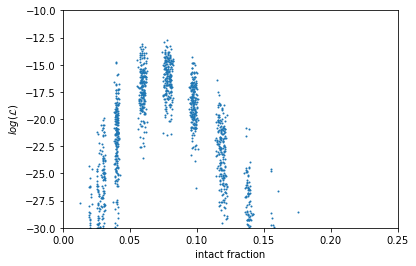

In [44]:
plt.scatter(0.4*df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero5.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0, 0.25)
plt.ylim(-30, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [45]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero5 > -460) & (df_exploded.intact_fracs > 0.17) 
                             & (df_exploded.intact_fracs < 0.23)]
print(np.mean(0.4*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero5))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero5))

0.07828273824427862 -16.283741398342077
200
-21.50802737665827


[309.6, 56.0, 23.6, 12.4, 6.0] [254.8, 37.6, 10.4, 4.0, 0.4] [278.67400000000004, 46.95800000000001, 17.252, 7.752000000000001, 2.3280000000000003]


[]

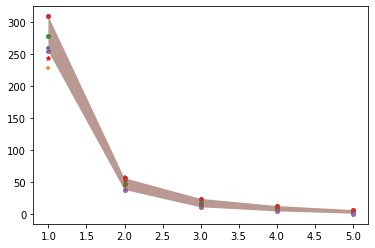

In [46]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero5]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.5

In [ ]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero6
lams = df_ten_billion.lams_nonzero6
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero6.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
#plt.xlim(0.05, 0.11)
plt.ylim(-100, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero6.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.1, 0.2)
plt.ylim(-100, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (df_exploded.intact_fracs > 0.13) 
                             & (df_exploded.intact_fracs < 0.17)]
print(np.mean(0.5*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero6))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

In [ ]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero6]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.6

In [ ]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero7
lams = df_ten_billion.lams_nonzero7
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero7.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.05, 0.2)
plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero7 > -460) & (df_exploded.intact_fracs > 0.09) 
                             & (df_exploded.intact_fracs < 0.11)]
print(np.mean(0.6*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero7))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero7))

In [ ]:
print(len(df_exploded), len(df_ten_billion))

In [ ]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero7]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.7

In [ ]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero8
lams = df_ten_billion.lams_nonzero8
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero8.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.05, 0.2)
plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero8 > -460) & (df_exploded.intact_fracs > 0.09) 
                             & (df_exploded.intact_fracs < 0.11)]
print(np.mean(0.7*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero8))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero8))

In [ ]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero8]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.8

In [ ]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero9
lams = df_ten_billion.lams_nonzero9
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero9.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0., 0.11)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero9 > -460) & (df_exploded.intact_fracs > 0.025) 
                             & (df_exploded.intact_fracs < 0.04)]
print(np.mean(0.8*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero9))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero9))

In [ ]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero9]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.9

In [ ]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero10
lams = df_ten_billion.lams_nonzero10
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero10.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.025, 0.04)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
print(np.argmax(df_ten_billion.logLs_nonzero10.explode()))
print(df_ten_billion.intact_fracs.explode().reset_index().intact_fracs[8403])

In [ ]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero10 > -460) & (df_exploded.intact_fracs > 0.025) 
                             & (df_exploded.intact_fracs < 0.04)]
print(np.mean(0.9*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero9))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero10))

In [ ]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero10]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 1.0

In [ ]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero11
lams = df_ten_billion.lams_nonzero11
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero10.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0., 0.16)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [ ]:
print(np.argmax(df_ten_billion.logLs_nonzero11.explode()))
print(df_ten_billion.intact_fracs.explode().reset_index().intact_fracs[8403])

In [ ]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero11 > -460) & (df_exploded.intact_fracs > 0.025) 
                             & (df_exploded.intact_fracs < 0.04)]
print(np.mean(1.*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero11))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero11))

In [ ]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero11]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.0

In [ ]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero1
lams = df_ten_billion.lams_nonzero1
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

In [ ]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero1.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
#plt.xlim(0., 0.16)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

### Introducing the intact vs disrupted vs logL plot

In [225]:
def calc_disrupted(scaling_factor, intact_frac):
    return scaling_factor*(1-intact_frac)

def calc_intact(scaling_factor, intact_frac):
    return scaling_factor*intact_frac

# for each scaling factor and its associated likeliest intact fraction, there is a corresponding (f_cold, f_hot)
# this means I can plot 11 points and compare them to the plot from Ballard & Moriarity
hotncold = pd.DataFrame()
hotncold['scaling_factor'] = np.linspace(0.1, 1., 10)
hotncold['likeliest_intact_frac'] = [0.08997801592468324, 0.0992281035605188, 0.08885199559316942, 0.07828273824427862, 
                        0.0741872402223446, 0.06009750112674646, 0.07011375131453754, 0.025652160849316433,
                        0.02885868095548099, 0.03206520106164553]

hotncold['disrupteds'] = calc_disrupted(hotncold.scaling_factor, hotncold.likeliest_intact_frac)
hotncold['intacts'] = calc_intact(scaling_factor, likeliest_intact_frac)
hotncold['best_logLs'] = [max(df_exploded.logLs_nonzero2), max(df_exploded.logLs_nonzero3),
                          max(df_exploded.logLs_nonzero4), max(df_exploded.logLs_nonzero5),
                          max(df_exploded.logLs_nonzero6), max(df_exploded.logLs_nonzero7),
                          max(df_exploded.logLs_nonzero8), max(df_exploded.logLs_nonzero9),
                          max(df_exploded.logLs_nonzero10), max(df_exploded.logLs_nonzero11)]
print(hotncold)


   scaling_factor  likeliest_intact_frac  disrupteds   intacts  best_logLs
0             0.1               0.089978    0.091002  0.008998 -116.296317
1             0.2               0.099228    0.180154  0.019846  -34.866663
2             0.3               0.088852    0.273344  0.026656  -13.109906
3             0.4               0.078283    0.368687  0.031313  -12.708956
4             0.5               0.074187    0.462906  0.037094  -21.190555
5             0.6               0.060098    0.563941  0.036059  -39.476943
6             0.7               0.070114    0.650920  0.049080  -64.962638
7             0.8               0.025652    0.779478  0.020522  -94.052729
8             0.9               0.028859    0.874027  0.025973 -124.951072
9             1.0               0.032065    0.967935  0.032065 -159.762510


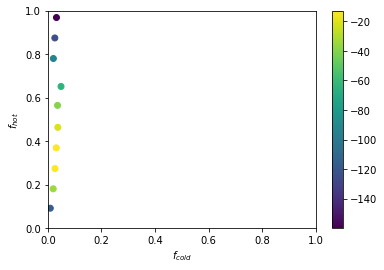

In [221]:
plt.scatter(hotncold.intacts, hotncold.disrupteds, c=hotncold.best_logLs)
plt.xlabel('$f_{cold}$')
plt.ylabel('$f_{hot}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()

#plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
#plt.yscale('log')

Okay, now we have to do this but not for the peaks of each scaling - rather, we do it for every point in the logL v intact fraction curve. 

In [212]:
pd.concat([df_ten_billion.intact_fracs.explode().reset_index()['intact_fracs'], 
          0.9*df_ten_billion.intact_fracs.explode().reset_index()['intact_fracs']], axis=0)

0          0
1          0
2          0
3          0
4          0
        ... 
12095    0.9
12096    0.9
12097    0.9
12098    0.9
12099    0.9
Name: intact_fracs, Length: 24200, dtype: object

In [223]:
df_ten_billion_logLs = [df_ten_billion.logLs_nonzero1.explode().reset_index().logLs_nonzero1, 
                       df_ten_billion.logLs_nonzero2.explode().reset_index().logLs_nonzero2,
                       df_ten_billion.logLs_nonzero3.explode().reset_index().logLs_nonzero3,
                       df_ten_billion.logLs_nonzero4.explode().reset_index().logLs_nonzero4,
                       df_ten_billion.logLs_nonzero5.explode().reset_index().logLs_nonzero5,
                       df_ten_billion.logLs_nonzero6.explode().reset_index().logLs_nonzero6,
                       df_ten_billion.logLs_nonzero7.explode().reset_index().logLs_nonzero7,
                       df_ten_billion.logLs_nonzero8.explode().reset_index().logLs_nonzero8,
                       df_ten_billion.logLs_nonzero9.explode().reset_index().logLs_nonzero9,
                       df_ten_billion.logLs_nonzero10.explode().reset_index().logLs_nonzero10]

-1283.9783211301603
-116.29631651833931
-34.86666280944553
-13.109906186799693
-12.708955525983777
-21.19055477062357
-39.476942823734326
-64.96263768833072
-94.05272861326979
-124.95107238150896


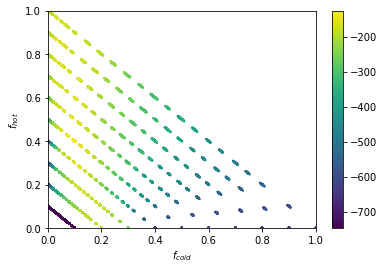

In [236]:
for i in range(10):
    hotncold = pd.DataFrame()
    hotncold['scaling_factor'] = 0.1*(i+1)*np.ones(12100)
    hotncold['pre_scaled_intacts'] = df_ten_billion.intact_fracs.explode().reset_index().intact_fracs
    hotncold['logLs'] = df_ten_billion_logLs[i]
    hotncold['disrupteds'] = calc_disrupted(hotncold.scaling_factor, hotncold.pre_scaled_intacts)
    hotncold['intacts'] = calc_intact(hotncold.scaling_factor, hotncold.pre_scaled_intacts)
    plt.scatter(hotncold.intacts, hotncold.disrupteds, c=hotncold.logLs, s=2)
    print(max(hotncold.logLs))

plt.xlabel('$f_{cold}$')
plt.ylabel('$f_{hot}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()
    

0
2074
12100
12100
12100
11909
11531
11085
10658
8713


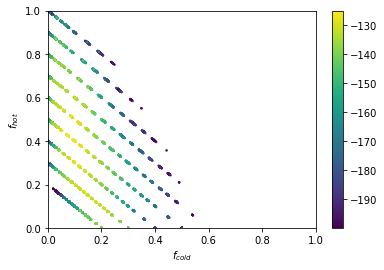

In [237]:
for i in range(10):
    hotncold = pd.DataFrame()
    hotncold['scaling_factor'] = 0.1*(i+1)*np.ones(12100)
    hotncold['pre_scaled_intacts'] = df_ten_billion.intact_fracs.explode().reset_index().intact_fracs
    hotncold['logLs'] = df_ten_billion_logLs[i]
    hotncold['disrupteds'] = calc_disrupted(hotncold.scaling_factor, hotncold.pre_scaled_intacts)
    hotncold['intacts'] = calc_intact(hotncold.scaling_factor, hotncold.pre_scaled_intacts)
    hotncold = hotncold.loc[hotncold.logLs > -200]
    plt.scatter(hotncold.intacts, hotncold.disrupteds, c=hotncold.logLs, s=2)
    print(len(hotncold.logLs))

plt.xlabel('$f_{cold}$')
plt.ylabel('$f_{hot}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()
    